In [182]:
import numpy as np    
from astropy.cosmology import Planck18 as cosmopy
from colossus.cosmology import cosmology
from colossus.lss import mass_function
from scipy.special import erf,erfc
from scipy.integrate import trapezoid as trapz, cumulative_trapezoid as cumtrapz
from scipy.interpolate import interp1d,interp2d
from scipy.optimize import minimize,basinhopping,curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm



In [183]:
cosmo=cosmology.setCosmology('myCosmo', params = cosmology.cosmologies['planck18'])

In [184]:
path='C:\\Users\\andre\\Desktop\Work\\astrobio\\'

#### Auxiliary functions

In [185]:
def MS(mstarlog,z):
#   res=(0.84-0.026*cosmo.age(z).value)*mstarlog-(6.51-0.11*cosmo.age(z).value) # Speagle+23
    # Popesso+23
    a_pop23=np.array([0.2,-0.034])
    b_pop23=np.array([-26.134,4.722,-0.1925])
    alpha_pop23=a_pop23[0]+a_pop23[1]*mstarlog
    beta_pop23=b_pop23[0]+b_pop23[1]*mstarlog+b_pop23[2]*mstarlog**2.
    res = alpha_pop23*np.sum(cosmo.age(z))+beta_pop23
    return res

def SMF(mstarlog,z,type):
    # Weaver+23 likelihood fit bestfit
    if type=='active':
        z_cosmos20=np.array([0.35,0.65,0.95,1.3,1.75,2.25,2.75,3.25,4.,5.])
        mstarlogchar_cosmos20=np.array([10.67,10.83,10.82,10.87,10.93,10.86,10.88,10.75,10.41,10.32])
        alpha1_cosmos20=np.array([-1.41,-1.4,-1.35,-1.35,-1.49,-1.47,-1.47,-1.47,-1.47,-1.47])
        phi1_cosmos20=1.e-3*np.array([0.87,0.7,0.84,0.74,0.25,0.24,0.25,0.22,0.21,0.13])
        alpha2_cosmos20=np.array([0.14,-0.36,0.06,0.79,-0.56,-0.03,0.,0.,0.,0.])
        phi2_cosmos20=1.e-3*np.array([0.63,0.32,0.39,0.13,0.31,0.13,0.,0.,0.,0.])
    elif type=='passive':
        z_cosmos20=np.array([0.35,0.65,0.95,1.3,1.75,2.25,2.75,3.25,4.,5.,6.,7.])
        mstarlogchar_cosmos20=np.array([10.97,10.90,10.87,10.64,10.49,10.5,10.33,10.39,10.61,10.82,0.,0.])
        alpha1_cosmos20=np.array([-2.05,-2.12,-2.01,-2.01,0.,0.,0.,0.,0.,0.,0.,0.])
        phi1_cosmos20=1.e-5*np.array([0.17,0.11,0.12,0.11,0.,0.,0.,0.,0.,0.,0.,0.])
        alpha2_cosmos20=np.array([-0.76,-0.49,-0.43,0.09,0.53,0.64,1.31,1.49,0.87,0.95,0.,0.])
        phi2_cosmos20=1.e-5*np.array([79.76,93.41,102.25,69.96,35.77,11.76,5.78,2.13,1.52,0.34,0.,0.])
    elif type=='total':
        z_cosmos20=np.array([0.35,0.65,0.95,1.3,1.75,2.25,2.75,3.25,4.,5.,6.,7.])
        mstarlogchar_cosmos20=np.array([10.92,10.98,11.01,11.,10.89,10.79,10.98,11.83,10.44,10.32,10.18,10.49])
        alpha1_cosmos20=np.array([-1.46,-1.45,-1.35,-1.34,-1.52,-1.47,-1.46,-1.46,-1.46,-1.46,-1.46,-1.46])
        phi1_cosmos20=1.e-3*np.array([0.59,0.48,0.71,0.68,0.29,0.26,0.23,0.21,0.2,0.13,0.05,0.01])
        alpha2_cosmos20=np.array([-0.66,0.-0.79,-0.72,-0.57,-0.56,0.07,0.,0.,0.,0.,0.,0.])
        phi2_cosmos20=1.e-3*np.array([1.12,0.95,0.74,0.34,0.65,0.31,0.,0.,0.,0.,0.,0.])
    restemp=np.log10(np.log(10.)*np.exp(-10.**(mstarlog[:,np.newaxis]-mstarlogchar_cosmos20[np.newaxis,:]))*(phi1_cosmos20[np.newaxis,:]*10.**((alpha1_cosmos20[np.newaxis,:]+1.)*(mstarlog[:,np.newaxis]-mstarlogchar_cosmos20[np.newaxis,:]))+phi2_cosmos20[np.newaxis,:]*10.**((alpha2_cosmos20[np.newaxis,:]+1.)*(mstarlog[:,np.newaxis]-mstarlogchar_cosmos20[np.newaxis,:]))))
#    restemp[mstarlog>13.]=-1000.
#    restemp[~np.isfinite(restemp)]=-1000.
    res=(interp1d(z_cosmos20,restemp,fill_value='extrapolate',kind='linear',axis=1))(z)
    return res

def frac_SB(mstarlog,z):
    zref=np.array([0.75,1.5,2.5,4.4,6.4])
    a1ref=np.array([-0.3,-0.3,-0.3,-0.3,-0.3])
    b1ref=np.array([2.52,2.73,2.82,3.045,3.045])
    a2ref=np.array([-0.0067,-0.05,-0.075,-0.131,-0.131])
    b2ref=np.array([0.1,0.555,0.817,1.408,1.408])
    m0logref=np.array([8.25,8.7,8.9,9.7,9.7])
    mfixlogref=np.array([7.6,7.99,8.24,9.25,9.25])
    a1=(interp1d(zref,a1ref,fill_value='extrapolate',kind='linear'))(z)
    b1=(interp1d(zref,b1ref,fill_value='extrapolate',kind='linear'))(z)
    a2=(interp1d(zref,a2ref,fill_value='extrapolate',kind='linear'))(z)
    b2=(interp1d(zref,b2ref,fill_value='extrapolate',kind='linear'))(z)
    m0log=(interp1d(zref,m0logref,fill_value='extrapolate',kind='linear'))(z)
    mfixlog=(interp1d(zref,mfixlogref,fill_value='extrapolate',kind='linear'))(z)
    res=0.03*mstarlog/mstarlog
    j0=mstarlog<=mfixlog
    res[j0]=(a1*mfixlog+b1)
    j1=np.logical_and(mstarlog>=mfixlog,mstarlog<=m0log)
    res[j1]=a1*mstarlog[j1]+b1
    j2=np.logical_and(mstarlog>=m0log,mstarlog<=10.5)
    res[j2]=(a2*mstarlog[j2]+b2)
    jsafe=res<0.03
    res[jsafe]=0.03
    return res

def FMR(mstarlog,sfrlog,z,kind):
    # Curti+20
    if kind=='Cu20':
        res=8.779-0.31/2.1*np.log10(1.+(10.**mstarlog/(10.**10.11*10.**(0.56*sfrlog)))**(-2.1))-8.76+np.log10(0.0153) # Curti+20
    elif kind=='Cu23':
        restemp=8.779-0.31/2.1*np.log10(1.+(10.**mstarlog/(10.**10.11*10.**(0.56*sfrlog)))**(-2.1))-8.76+np.log10(0.0153) # Curti+20
        offset_z=np.array([0.,1.,2.,3.,4.255,5.775,7.665])
        offset_fmr=np.array([0.,0.,0.,0.,-2.284e-1,-3.430e-1,-5.147e-1])
        res=restemp+(interp1d(offset_z,offset_fmr,fill_value='extrapolate',kind='linear'))(z)
    elif kind=='AM13':
        restemp=0.43*(mstarlog-0.66*sfrlog)+4.58-8.76+np.log10(0.0153) # Andrews & Martini 13
        offset_z=np.array([0.,1.,2.,3.,4.,4.98,6.86,8.47])
        offset_fmr=np.array([0.,0.,0.,0.,0.,-0.096,-0.086,-0.34])
        res=restemp+(interp1d(offset_z,offset_fmr,fill_value='extrapolate',kind='linear'))(z)    
    return res

def IMF(mslogout,imf_type):
    nms=1000
    mslog=np.linspace(np.log10(0.08),np.log10(300.),nms)
    ms=10.**mslog
    restemp=np.zeros(nms)
    if imf_type == 'Salpeter':
        restemp=ms**(-2.35)
    if imf_type == 'Scalo':
        j1 = ms < 1.
        restemp[j1]=ms[j1]**(-1.8)
        j2= np.logical_and(ms>=1,ms<10)
        restemp[j2]=ms[j2]**(-3.25)
        j3 = ms>10
        restemp[j3]=0.16*ms[j3]**(-2.45)
    elif imf_type == 'Kroupa':
        j1 = ms < 0.5
        restemp[j1]=2.*ms[j1]**(-1.3)
        j2= np.logical_and(ms>=0.5,ms<10)
        restemp[j2]=ms[j2]**(-2.3)
        j3=ms>10
        restemp[j3]=10.**0.4*ms[j3]**(-2.7)
    elif imf_type == 'Chabrier':
        j1=ms<1.            
        restemp[j1]=3.58/ms[j1]*np.exp(-1.050*(np.log10(ms[j1]/0.079))**2.)
        j2=ms>=1.
        restemp[j2]=ms[j2]**(-2.3)
    elif imf_type == 'SISSA':
        j1=ms<1.            
        restemp[j1]=ms[j1]**(-1.4)
        j2=ms>=1.
        restemp[j2]=ms[j2]**(-2.35)
    resnorm=trapz(restemp*ms**2.,mslog)*np.log(10.)
    res=restemp/resnorm
    return (interp1d(mslog,res,fill_value='extrapolate',kind='linear'))(mslogout)

def agems(mslog,zetalogout):
    nms=len(mslog)
    zeta=np.array([0.0005,0.001,0.01,0.02])
    nzeta=len(zeta)
    agelog_temp=np.zeros((nms,nzeta))
    age_coeff=np.array([9.79557792,-3.23964917,0.77910623,0.08845161,-0.04035509]) 
    agelog_temp[:,0]=age_coeff[0]+age_coeff[1]*mslog+age_coeff[2]*mslog**2.+age_coeff[3]*mslog**3.+age_coeff[4]*mslog**4.
    age_coeff=np.array([9.8561528,-3.38621481,0.91448315,0.03416141,-0.03254432]) 
    agelog_temp[:,1]=age_coeff[0]+age_coeff[1]*mslog+age_coeff[2]*mslog**2.+age_coeff[3]*mslog**3.+age_coeff[4]*mslog**4.
    age_coeff=np.array([10.26292972,-4.21389943,1.49512165,-0.13787199,-0.01398241]) 
    agelog_temp[:,2]=age_coeff[0]+age_coeff[1]*mslog+age_coeff[2]*mslog**2.+age_coeff[3]*mslog**3.+age_coeff[4]*mslog**4.
    age_coeff=np.array([10.39792464,-4.4614218,1.62400155,-0.15687709,-0.01421212]) 
    agelog_temp[:,3]=age_coeff[0]+age_coeff[1]*mslog+age_coeff[2]*mslog**2.+age_coeff[3]*mslog**3.+age_coeff[4]*mslog**4.
    agelog=(interp1d(np.log10(zeta),agelog_temp,fill_value='extrapolate',kind='linear',axis=1))(zetalogout)
    return 10.**agelog



In [186]:
#jms=ms>2.# da fare bene a tempo debito 
#trapz(IMF(mslog[jms],0.,0.,'Chabrier')*ms[jms]**2.,mslog[jms])*np.log(10.)


### Variables and scales

In [187]:
nmstar=100
mstarlog=np.linspace(6.,13.,nmstar)
mstar=10**mstarlog

nsfr=100
sfrlog=np.linspace(-4.,4.,nsfr)
sfr=10.**sfrlog

nzeta=100
zetalog=np.linspace(-6.,4.,nzeta)
zeta=10.**zetalog
zeta_sun=0.0153

nz=100
z=np.linspace(0.01,12.01,nz)
tz=cosmo.age(z)

nms=1000
mslog=np.linspace(np.log10(0.08),np.log10(300.),nms)
ms=10.**mslog

msmin_Mdw=0.1
msmax_Mdw=0.6
msmin_FGK=0.6
msmax_FGK=1.2

sigma_MS=0.2
sigma_SB=0.25
offset_SB=0.6

kind='Cu23'
#kind='AM13'
sigma_FMR=0.35#0.35



### Galactic term

In [188]:
rhosfr_zeta=np.zeros((nzeta,nz))
rhosfr_mstarzeta=np.zeros((nmstar,nzeta,nz))
for iz in range(nz):
    sfrlog_MS=MS(mstarlog[:,np.newaxis,np.newaxis],z[iz])
    sfrlog_SB=sfrlog_MS+offset_SB
    norm_SB=frac_SB(mstarlog[:,np.newaxis,np.newaxis],z[iz])
    norm_MS=1.-norm_SB
    prob_sfr=(norm_MS*np.exp(-(sfrlog[np.newaxis,:,np.newaxis]-sfrlog_MS)**2./2./sigma_MS**2.)/np.sqrt(2.*np.pi*sigma_MS**2.)+norm_SB*np.exp(-(sfrlog[np.newaxis,:,np.newaxis]-sfrlog_SB)**2./2./sigma_SB**2.)/np.sqrt(2.*np.pi*sigma_SB**2.))*zetalog[np.newaxis,np.newaxis,:]/zetalog[np.newaxis,np.newaxis,:]
    zetalog_FMR=FMR(mstarlog[:,np.newaxis,np.newaxis],sfrlog[np.newaxis,:,np.newaxis],z[iz],kind)*zetalog[np.newaxis,np.newaxis,:]/zetalog[np.newaxis,np.newaxis,:]
    prob_zeta=np.exp(-(zetalog[np.newaxis,np.newaxis,:]-zetalog_FMR)**2./2./sigma_FMR**2.)/np.sqrt(2.*np.pi*sigma_FMR**2.)
    
    temp1=trapz(prob_zeta*prob_sfr*sfr[np.newaxis,:,np.newaxis],sfrlog,axis=1)
    temp2=trapz((10.**SMF(mstarlog,z[iz],'active'))[:,np.newaxis]*temp1,mstarlog,axis=0)
    rhosfr_mstarzeta[:,:,iz]=(10.**SMF(mstarlog,z[iz],'active'))[:,np.newaxis]*temp1
    rhosfr_zeta[:,iz]=temp2
rhosfr=trapz(rhosfr_zeta,zetalog,axis=0)



In [189]:
# SFR density of galaxies that will become passive @ z=0 [neglecting merging]

# relazione mass-sigma by Thomas+05
sigmastarlog=(mstarlog-0.63)/4.52
# relazione mass-sigma by Cappellari+13
#sigmastarlog=2.153+0.442*(mstarlog-10.675)+(0.215-0.442)/8.*np.log10(0.5+0.5*(mstar/10.**10.675)**8.)

# formation times from stellar ages by Thomas+10
#tform_th10=cosmo.age(0.)-10.**(-0.53+0.13*mstarlog)
tform_th10=cosmo.age(0.)-10.**(-0.11+0.47*sigmastarlog)
jform_low=tform_th10<0.01
tform_th10[jform_low]=0.01
jform_high=tform_th10>cosmo.age(0.)
tform_th10[jform_high]=cosmo.age(0.)
tformlog_th10=np.log10(tform_th10)
zform_th10=cosmo.age(tform_th10,inverse=True)
sigma_tformlog=0.25

# burst duration time from alpha enhancement by Thomas+10
#alphenh_th10=-0.95+0.1*mstarlog
alphenh_th10=-0.55+0.33*sigmastarlog
dtburst=10.**(6.*(-alphenh_th10+0.2))
sigma_tburst=dtburst/2.355
jburst_low=sigma_tburst<0.01
sigma_tburst[jburst_low]=0.01
jburst_high=sigma_tburst>cosmo.age(0.)
sigma_tburst[jburst_high]=cosmo.age(0.)

# metallicity  by Thomas+10
#zetalog_th10=-2.40+0.22*mstarlog+np.log10(zeta_sun)
zetalog_th10=-1.34+0.65*sigmastarlog+np.log10(zeta_sun)

rest=0.45

ntform=100
tformlog=np.linspace(np.log10(0.01),np.log10(cosmo.age(0.)),ntform)
tform=10.**tformlog
rhosfr_pass=np.zeros(nz)
rhosfr_pass_masscut=np.zeros(nz)
rhosfr_mstarpass=np.zeros((nmstar,nz))
rhosfr_zetapass=np.zeros((nzeta,nz))
for iz in range(nz):
    tz=cosmo.age(z[iz])
    sfrpass=mstar[:,np.newaxis]/(1.-rest)/np.sqrt(2.*np.pi*sigma_tburst[:,np.newaxis]**2.)*np.exp(-(tz-tform[np.newaxis,:])**2./2./sigma_tburst[:,np.newaxis]**2.)/1.e9  # Msun/yr   
    prob_tformlog=1./np.sqrt(2.*np.pi*sigma_tformlog**2.)*np.exp(-(tformlog[np.newaxis,:]-tformlog_th10[:,np.newaxis])**2./2./sigma_tformlog**2.)
    temp1pass=trapz(prob_tformlog*sfrpass,tformlog,axis=1)/trapz(prob_tformlog,tformlog,axis=1)
    temp2pass=trapz((10.**SMF(mstarlog,0.,'passive'))*temp1pass,mstarlog,axis=0)
    rhosfr_pass[iz]=temp2pass

    jcut=mstarlog>10.5
    temp2pass_masscut=trapz(10.**SMF(mstarlog[jcut],0.,'passive')*temp1pass[jcut],mstarlog[jcut],axis=0)
    rhosfr_pass_masscut[iz]=temp2pass_masscut

    mstarpass=mstar[:,np.newaxis]/(1.-rest)/2.*(1.+erf((tz-tform[np.newaxis,:])/np.sqrt(2.)/sigma_tburst[:,np.newaxis]))
    jsafepass=mstarpass<=0
    mstarpass[jsafepass]=1.e-33
    zetalog_pass=FMR(np.log10(mstarpass[:,:,np.newaxis]),np.log10(sfrpass[:,:,np.newaxis]),z[iz],kind)*zetalog[np.newaxis,np.newaxis,:]/zetalog[np.newaxis,np.newaxis,:]
    prob_zetapass=np.exp(-(zetalog[np.newaxis,np.newaxis,:]-zetalog_pass)**2./2./sigma_FMR**2.)/np.sqrt(2.*np.pi*sigma_FMR**2.)
    temp1zetapass=trapz(prob_tformlog[:,:,np.newaxis]*sfrpass[:,:,np.newaxis]*prob_zetapass,tformlog,axis=1)/(trapz(prob_tformlog,tformlog,axis=1))[:,np.newaxis]
    temp2zetapass=trapz((10.**SMF(mstarlog,0.,'passive'))[:,np.newaxis]*temp1zetapass,mstarlog,axis=0)
    rhosfr_zetapass[:,iz]=temp2zetapass

 
    temp0mstarpass=prob_tformlog*sfrpass/np.abs(np.gradient(np.log10(mstarpass),mstarlog,axis=0))*10.**SMF(mstarlog,0.,'passive')[:,np.newaxis]
#    temp0mstarpass=prob_tformlog*sfrpass/np.abs(1.+sfrpass*(tz-tform[np.newaxis,:])/mstarpass*(np.gradient(np.log10(sigma_tburst),mstarlog))[:,np.newaxis])*10.**SMF(mstarlog,0.,'passive')[:,np.newaxis] # analitica
    temp0mstarpass[~np.isfinite(temp0mstarpass)]=0.
    temp1mstarpass=np.zeros((nmstar,ntform))
    for iform in range(ntform):
#        temp1mstarpass[:,iform]=10.**(interp1d(np.log10(mstarpass[:,iform]),np.log10(temp0mstarpass[:,iform]),fill_value='extrapolate',kind='linear')(mstarlog))
        temp1mstarpass[:,iform]=10.**(interp1d(mstarlog,np.log10(temp0mstarpass[:,iform]),fill_value='extrapolate',kind='linear')(np.log10(mstarpass[:,iform])))

    temp2mstarpass=trapz(temp1mstarpass,tformlog,axis=1)/trapz(prob_tformlog,tformlog,axis=1)    
    temp2mstarpass[~np.isfinite(temp2mstarpass)]=1.e-33
    rhosfr_mstarpass[:,iz]=temp2mstarpass

#rhosfr_check=trapz(rhosfr_mstarpass,mstarlog,axis=0)

fracsfr_pass=rhosfr_pass/rhosfr
fracsfr_pass[0]=0.5
jpass=fracsfr_pass>1.
fracsfr_pass[jpass]=1.
rhosfr_pass=rhosfr*fracsfr_pass


C:\Users\andre\AppData\Local\Temp\ipykernel_3644\1854323024.py:34: RuntimeWarning: divide by zero encountered in log10
  restemp=np.log10(np.log(10.)*np.exp(-10.**(mstarlog[:,np.newaxis]-mstarlogchar_cosmos20[np.newaxis,:]))*(phi1_cosmos20[np.newaxis,:]*10.**((alpha1_cosmos20[np.newaxis,:]+1.)*(mstarlog[:,np.newaxis]-mstarlogchar_cosmos20[np.newaxis,:]))+phi2_cosmos20[np.newaxis,:]*10.**((alpha2_cosmos20[np.newaxis,:]+1.)*(mstarlog[:,np.newaxis]-mstarlogchar_cosmos20[np.newaxis,:]))))
C:\Users\andre\AppData\Local\Temp\ipykernel_3644\593033294.py:57: RuntimeWarning: divide by zero encountered in log10
  zetalog_pass=FMR(np.log10(mstarpass[:,:,np.newaxis]),np.log10(sfrpass[:,:,np.newaxis]),z[iz],kind)*zetalog[np.newaxis,np.newaxis,:]/zetalog[np.newaxis,np.newaxis,:]
C:\Users\andre\AppData\Local\Temp\ipykernel_3644\1854323024.py:70: RuntimeWarning: divide by zero encountered in divide
  restemp=8.779-0.31/2.1*np.log10(1.+(10.**mstarlog/(10.**10.11*10.**(0.56*sfrlog)))**(-2.1))-8.76+np.log

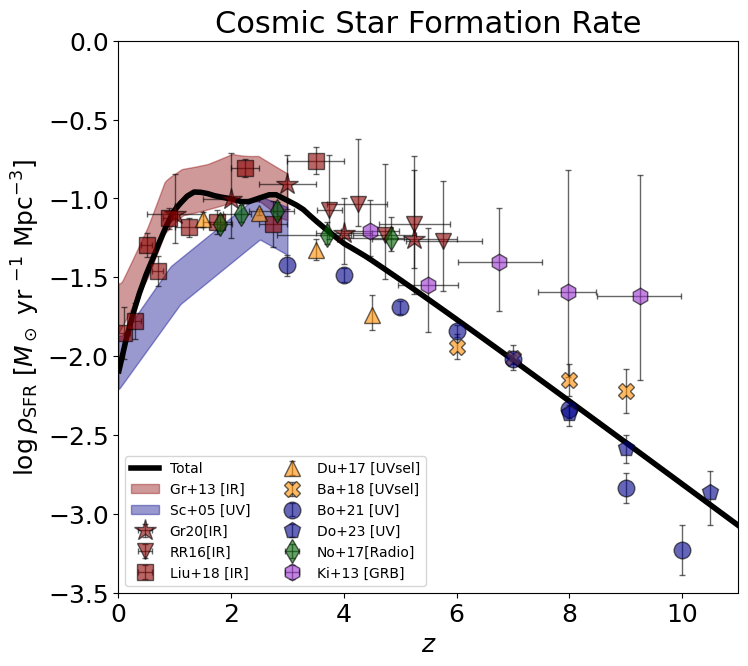

In [190]:
fig, ax=plt.subplots(figsize=(8,8))
fig.subplots_adjust(top=0.8)
ax.set(xlim=(0.,11.), ylim=(-3.5,0.))
ax.set_title('Cosmic Star Formation Rate',fontsize=22)
ax.set_xlabel('$z$',fontsize=18.)
ax.set_ylabel('$\\log\\rho_{\\rm SFR}$ [$M_\\odot$ yr $^{-1}$ Mpc$^{-3}$]',fontsize=18.)
ax.tick_params(axis='both', labelsize=18)

ax.plot(z,np.log10(rhosfr),c='black',ls='-',lw=4,label='Total')

jz=z<8.
#ax.plot(z[jz],np.log10(rhosfr_pass[jz]),c='black',ls=':',lw=4,label='In quiescent @ $z\\sim 0$')
#ax.plot(z[jz],np.log10(rhosfr_pass_masscut[jz]),c='red',ls='--',lw=4,label='In quiescent @ $z\\sim 0$')
#ax.plot(z[jz],np.log10(rhosfr[jz]-rhosfr_pass[jz]),c='black',ls='--',lw=4,label='In starforming @ $z\\sim 0$')
#ax.plot(z[jz],np.log10(rhosfr_check[jz]),c='red',ls='-',lw=4,alpha=0.6)

#submm by Gruppioni+20 
z_gr20=np.array([1.,2.,3.,4.,5.25])
rholog_gr20=np.log10(np.array([7.93e-2,9.96e-2,1.23e-1,6.06e-2,5.57e-2]))
rhologerrp_gr20=( np.log10(np.array([1.42e-1,1.94e-1,1.88e-1,1.e-1,1.51e-1]))) - rholog_gr20
rhologerrm_gr20= rholog_gr20 - ( np.log10(np.array([5.19e-2,5.64e-2,8.57e-2,3.82e-2,2.49e-2])))
xm_gr20=np.array([0.5,1.5,2.5,3.5,4.5])
xp_gr20=np.array([1.5,2.5,3.5,4.5,6])
ax.errorbar(z_gr20,rholog_gr20,xerr=[z_gr20-xm_gr20,xp_gr20-z_gr20],yerr=[rhologerrm_gr20,rhologerrp_gr20], marker='*',markersize=16,markeredgecolor='black',markeredgewidth=1,elinewidth=1,fillstyle='full', c='darkred',ecolor='black',capsize=2.,ls='none',alpha=0.6, label='Gr20[IR]')

#IR data hermes alto z da Rowan-Robinson+16
x_rr16=np.array([3.74,4.25,4.73,5.25,5.76])
y_rr16=10.**(np.array([-8.22e-1,-7.85e-1,-9.85e-1,-9.15e-1,-1.02e+0]))/(10.**0.25)
yp_rr16=10.**(np.array([-6.34e-1,-6.45e-1,-7.08e-1,-6.38e-1,-7.04e-1]))/(10.**0.25)
ym_rr16=10.**(np.array([-1.17e+0,-1.20e+0,-1.44e+0,-1.35e+0,-1.40e+0]))/(10.**0.25)
xm_rr16=np.array([3.51,3.73,4.18,4.61,5.07])
xp_rr16=np.array([3.95,4.79,5.29,5.87,6.42])
ax.errorbar(x_rr16,np.log10(y_rr16),xerr=[xp_rr16-x_rr16,x_rr16-xm_rr16],yerr=[np.log10(yp_rr16)-np.log10(y_rr16),np.log10(y_rr16)-np.log10(ym_rr16)],marker='v',markersize=12,markeredgecolor='black',markeredgewidth=1,elinewidth=1,fillstyle='full', c='darkred',ecolor='black',capsize=2.,ls='none',alpha=0.6, label='RR16[IR]')

# IR dati da Liu+18
x_liu17=np.array([0.1,0.3,0.5,0.7,0.9,1.25,1.75,2.25,2.75,3.5])
xerr_liu17=np.array([0.1,0.1,0.1,0.1,0.1,0.25,0.25,0.25,0.25,0.5])
y_liu17=np.array([-1.852,-1.776,-1.293,-1.462,-1.125,-1.183,-1.150,-0.806,-1.161,-0.762])
yerr_liu17=np.array([0.164,0.114,0.077,0.096,0.067,0.062,0.075,0.057,0.146,0.086])
ax.errorbar(x_liu17,y_liu17,xerr=xerr_liu17,yerr=yerr_liu17, marker='s',markersize=12,markeredgecolor='black',markeredgewidth=1,elinewidth=1,fillstyle='full', c='darkred',ecolor='black',capsize=2.,ls='none',alpha=0.6,label='Liu+18 [IR]')

#IR data from ALMA in HUDF by Dunlop+17
x_du16=np.array([1.5,2.5,3.5,4.5])
y_du16=10.**(np.array([-1.132,-1.091,-1.327,-1.741]))
yp_du16=10.**(np.array([-1.086,-1.074,-1.265,-1.649]))
ym_du16=10.**(np.array([-1.179,-1.115,-1.395,-1.867]))
ax.errorbar(x_du16,np.log10(y_du16),xerr=None,yerr=[np.log10(yp_du16)-np.log10(y_du16),np.log10(y_du16)-np.log10(ym_du16)], marker='^',markersize=12,markeredgecolor='black',markeredgewidth=1,elinewidth=1,fillstyle='full', c='darkorange',ecolor='black',capsize=2.,ls='none',alpha=0.6, label='Du+17 [UVsel]')

#dati UV integrati fino a M_uv=-13.5 da Bhatawdekar+18
z_ba18=np.array([6.,7.,8.,9.])
sfrlog_uv_ba18=np.array([-1.69,-1.76,-1.90,-1.97])-0.25
sfrlog_uv_err_ba18=np.array([0.08,0.08,0.1,0.14])
ax.errorbar(z_ba18,sfrlog_uv_ba18,yerr=sfrlog_uv_err_ba18, marker='X',markersize=12,markeredgecolor='black',markeredgewidth=1,elinewidth=1,fillstyle='full', c='darkorange',ecolor='black',capsize=2.,ls='none',alpha=0.6,label='Ba+18 [UVsel]')

zplot=np.linspace(0.,3.,100)
#z_uv_up=np.array([1.70e-2,9.27e-1,2.45e+0,3.88e+0,7.87e+0,1.14e+1])
#sfrlog_uv_up=np.array([-2.47,-1.80,-1.18,-1.30,-2.16,-3.38])-0.25
#z_uv_down=np.array([8.51e-3,9.78e-1,2.51e+0,3.68e+0,4.68e+0,6.05e+0,6.90e+0,7.84e+0,9.81e+0,1.14e+1])
#sfrlog_uv_down=np.array([-2.66,-2.02,-1.36,-1.48,-1.65,-1.95,-2.10,-2.34,-3.05,-3.75])-0.25
z_uvcorr_up=np.array([6.88e-2,9.27e-1,2.48e+0,3.99e+0,8.05e+0,1.14e+1])
sfrlog_uvcorr_up=np.array([-1.62e0,-1.18e+0,-7.31e-1,-9.46e-1,-2.03e+0,-3.33e+0])-0.25
z_uvcorr_down=np.array([8.51e-3,1.10e+0,2.51e+0,4.37e+0,7.84e+0,1.15e+1])
sfrlog_uvcorr_down=np.array([-1.96,-1.42,-1.01,-1.38,-2.24,-3.67])-0.25
#plt.fill_between(zplot,np.interp(zplot,z_uvcorr_down,sfrlog_uvcorr_down),np.interp(zplot,z_uvcorr_up,sfrlog_uvcorr_up),alpha=0.5,color='dodgerblue',label='Sch05[UV]')
z_ir_down=np.array([8.51e-3,5.19e-1,8.25e-1,1.15e+0,2.17e+0,2.91e+0])
sfrlog_ir_down=np.array([-1.85,-1.44,-1.10,-1.00,-1.01,-1.29])-0.25
z_ir_up=np.array([4.25e-2,5.19e-1,8.25e-1,1.13e+0,1.59e+0,2.02e+0,2.99e+0])
sfrlog_ir_up=np.array([-1.56e+0,-1.12e+0,-7.71e-1,-7.04e-1,-7.18e-1,-6.91e-1,-1.00e+0])-0.25
ax.fill_between(zplot,np.log10(10.**(np.interp(zplot,z_ir_down,sfrlog_ir_down))+10.**(np.interp(zplot,z_uvcorr_down,sfrlog_uvcorr_down))),np.log10(10.**(np.interp(zplot,z_ir_up,sfrlog_ir_up))+10.**(np.interp(zplot,z_uvcorr_up,sfrlog_uvcorr_up))),alpha=0.4,color='darkred',label='Gr+13 [IR]')
ax.fill_between(zplot,np.interp(zplot,z_uvcorr_down,sfrlog_uvcorr_down),np.interp(zplot,z_uvcorr_up,sfrlog_uvcorr_up),color='darkblue',alpha=0.4,label='Sc+05 [UV]')

# data UV HST by Bouwens+21,Oesch+18
z_bo21=np.array([3.,4.,5.,6.,7.,8.,9.,10])
rhologm_bo21=np.array([26.51,26.47,26.27,26.12,25.95,25.61,25.07,24.77+0.16])-np.log10(1.e28)
rhologp_bo21=np.array([26.64,26.56,26.35,26.2,26.01,25.72,25.26,24.77-0.16])-np.log10(1.e28)
rholog_bo21=0.5*(rhologp_bo21+rhologm_bo21)
rhologerrp_bo21=rhologp_bo21-rholog_bo21
rhologerrm_bo21=rholog_bo21-rhologm_bo21
ax.errorbar(z_bo21,rholog_bo21,yerr=[rhologerrm_bo21,rhologerrp_bo21], marker='o',markersize=12,markeredgecolor='black',markeredgewidth=1,elinewidth=1,fillstyle='full', c='darkblue',ecolor='black',capsize=2.,ls='none',alpha=0.6,label='Bo+21 [UV]')

# data UV JWST by Bouwens+23
z_bo23=np.array([8.,10.,12.9,17.6])
rholog_bo23=np.array([25.21,24.69,24.39,24.39])+0.5-np.log10(1.e28)#-np.log10(1.4e28) # 0.5 approximately accounts to pass from -19 to -17
rhologerrp_bo23=np.array([0.28,0.14,0.23,0.52])
rhologerrm_bo23=np.array([0.28,0.14,0.27,0.7])
#ax.errorbar(z_bo23,rholog_bo23,yerr=[rhologerrm_bo23,rhologerrp_bo23], marker='p',markersize=12,markeredgecolor='black',markeredgewidth=1,elinewidth=1,fillstyle='full', c='darkgrey',ecolor='darkgrey',capsize=2.,ls='none',alpha=0.6)
#solid
z_bo23sol=np.array([10.,13.,17.])
rholog_bo23sol=np.array([24.86,24.92,24.68])+0.5-np.log10(1.e28)
rhologerrp_bo23sol=np.array([0.08,0.09,0.14])
rhologerrm_bo23sol=np.array([0.08,0.09,0.14])
#ax.errorbar(z_bo23sol,rholog_bo23sol,yerr=[rhologerrm_bo23sol,rhologerrp_bo23sol], marker='*',markersize=10,markeredgecolor='black',markeredgewidth=1,elinewidth=1,fillstyle='full', c='darkred',ecolor='darkgrey',capsize=2.,ls='none',alpha=1,label='Bo+23 solid')

#data UV JWST by Donnan+23
z_do23=np.array([8.,9.,10.5,11.2,13.25])
rholog_do23=np.array([25.64,25.42,25.14,24.97,24.31])-np.log10(1.e28)
rhologm_do23=np.array([25.56,25.32,24.93,24.61,24.05])-np.log10(1.e28)
rhologp_do23=np.array([25.69,25.50,25.27,25.18,24.46])-np.log10(1.e28)
rhologerrp_do23=rhologp_do23-rholog_do23
rhologerrm_do23=rholog_do23-rhologm_do23
ax.errorbar(z_do23,rholog_do23,yerr=[rhologerrm_do23,rhologerrp_do23], marker='p',markersize=12,markeredgecolor='black',markeredgewidth=1,elinewidth=1,fillstyle='full', c='darkblue',ecolor='black',capsize=2.,ls='none',alpha=0.6,label='Do+23 [UV]')

# data UV JWST by Harikane+23
z_ha23=np.array([9.,12.,16.])
rholog_ha23=np.array([25.28,24.61,24.24])-np.log10(1.e28)
rhologerrp_ha23=np.array([0.19,0.26,0.33])
rhologerrm_ha23=np.array([0.16,0.26,2.83])
#ax.errorbar(z_ha23,rholog_ha23,yerr=[rhologerrm_ha23,rhologerrp_ha23], marker='*',markersize=12,markeredgecolor='black',markeredgewidth=1,elinewidth=1,fillstyle='full', c='darkblue',ecolor='black',capsize=2.,ls='none',alpha=0.6)

#radio data from Novak+17
x_no17=np.array([1.16,1.44,1.81,2.18,2.81,3.71,4.83])
xp_no17=np.array([0.14,0.16,0.19,0.32,0.49,0.89,0.87])
xm_no17=np.array([0.16,0.14,0.21,0.18,0.31,0.41,0.23])
y_no17=np.array([-1.31,-1.24,-1.16,-1.10,-1.08,-1.23,-1.25])
yp_no17=np.array([0.043,0.045,0.047,0.048,0.052,0.062,0.085])
ym_no17=np.array([0.049,0.051,0.053,0.056,0.06,0.079,0.13])
jplot_no17=x_no17>1.5
ax.errorbar(x_no17[jplot_no17],y_no17[jplot_no17],xerr=[xp_no17[jplot_no17],xm_no17[jplot_no17]],yerr=[yp_no17[jplot_no17],ym_no17[jplot_no17]], marker='d',markersize=12,markeredgecolor='black',markeredgewidth=1,elinewidth=1,fillstyle='full', c='darkgreen',ecolor='black',capsize=2.,ls='none',alpha=0.6, label='No+17[Radio]')

#GRB data from Kistler+13
x_ki13=np.array([4.47,5.49,6.76,7.98,9.25])
y_ki13=np.array([1.10e-1,5.05e-2,7.06e-2,4.56e-2,4.27e-2])/(10.**0.25)
yp_ki13=np.array([1.58e-1,1.01e-1,1.45e-1,1.58e-1,1.45e-1])/(10.**0.25)
ym_ki13=np.array([6.97e-2,2.22e-2,3.22e-2,7.73e-3,7.24e-3])/(10.**0.25)
xp_ki13=np.array([4.99,6.01,7.50,8.51,10.0]) 
xm_ki13=np.array([3.96,4.95,6.01,7.49,8.51])
jplot_ki13=x_ki13<=10
ax.errorbar(x_ki13[jplot_ki13],np.log10(y_ki13[jplot_ki13]),xerr=[xp_ki13[jplot_ki13]-x_ki13[jplot_ki13],x_ki13[jplot_ki13]-xm_ki13[jplot_ki13]],yerr=[np.log10(yp_ki13[jplot_ki13])-np.log10(y_ki13[jplot_ki13]),np.log10(y_ki13[jplot_ki13])-np.log10(ym_ki13[jplot_ki13])], marker='h',markersize=12,markeredgecolor='black',markeredgewidth=1,elinewidth=1,fillstyle='full', c='darkorchid',ecolor='black',capsize=2.,ls='none',alpha=0.6, label='Ki+13 [GRB]')

# Behiri+23 NIR-dark
x_beh23=np.array([1.,2.5,4.])
xerr_beh23=np.array([1.,0.5,1.])
#y_beh23=np.log10(np.array([0.6,2.4,5.])*1.e-3)
#yerr_beh23=np.log10(10.**y_beh23+np.array([0.1,0.4,0.7])*1.e-3)-y_beh23
y_beh23=np.log10(np.array([0.8,3.2,6.2])*1.e-3)
yerr_beh23=np.log10(10.**y_beh23+np.array([0.1,0.5,0.6])*1.e-3)-y_beh23
jbeh23=x_beh23>3.
#ax.errorbar(x_beh23[jbeh23],y_beh23[jbeh23],xerr=xerr_beh23[jbeh23],yerr=yerr_beh23[jbeh23], marker=None,markersize=12,markeredgecolor='black',markeredgewidth=1,elinewidth=1,fillstyle='full', c='darkblue',ecolor='black',capsize=2.,ls='none',alpha=0.6)

# Talia+21 NIR-dark
x_tal21=np.array([1.,2.5,3.75,6.])
xerr_tal21=np.array([1.,0.5,0.75,1.5])
y_tal21=np.log10(np.array([6.8,2.8,7.1,5.2])*1.e-3)
yerr_tal21=np.log10(10.**y_tal21+np.array([1.3,0.5,1.7,1.3])*1.e-3)-y_tal21
jtal21=x_tal21>2.5
#ax.errorbar(x_tal21[jtal21],y_tal21[jtal21],xerr=xerr_tal21[jtal21],yerr=yerr_tal21[jtal21], marker=None,markersize=12,markeredgecolor='black',markeredgewidth=1,elinewidth=1,fillstyle='full', c='darkblue',ecolor='black',capsize=2.,ls='none',alpha=0.6)
#for i in range(len(x_tal21[jtal21])):
#   ax.add_patch(mpatches.Rectangle((x_tal21[jtal21][i]-xerr_tal21[jtal21][i],y_tal21[jtal21][i]-yerr_tal21[jtal21][i]),2.*xerr_tal21[jtal21][i],2.*yerr_tal21[jtal21][i],color='darkgrey',alpha=0.3,hatch='\\'))


# Gruppioni+20 HST-dark
x_gru20=np.array([3.,5.])
xerr_gru20=np.array([1.,1.])
y_gru20=np.log10(np.array([1.5e-2,0.9e-2]))
yerr_gru20=np.log10(10.**y_gru20+np.array([0.9e-2,0.7e-2]))-y_gru20
jgru20=x_gru20>2.5
#ax.errorbar(x_gru20[jgru20],y_gru20[jgru20],xerr=xerr_gru20[jgru20],yerr=yerr_gru20[jgru20], marker=None,markersize=12,markeredgecolor='black',markeredgewidth=1,elinewidth=1,fillstyle='full', c='darkblue',ecolor='black',capsize=2.,ls='none',alpha=0.6)
#for i in range(len(x_gru20)):
#   ax.add_patch(mpatches.Rectangle((x_gru20[i]-xerr_gru20[i],y_gru20[i]-yerr_gru20[i]),2.*xerr_gru20[i],2.*yerr_gru20[i],color='darkgrey',alpha=0.3,hatch='/'))
#i=0
#ax.add_patch(mpatches.Rectangle((x_gru20[i]-xerr_gru20[i],y_gru20[i]-yerr_gru20[i]),2.*xerr_gru20[i],2.*yerr_gru20[i],color='darkgrey',alpha=0.3,hatch='/',label='Gr+20 [HST-dark]'))
#ax.add_patch(mpatches.Rectangle((x_tal21[jtal21][i]-xerr_tal21[jtal21][i],y_tal21[jtal21][i]-yerr_tal21[jtal21][i]),2.*xerr_tal21[jtal21][i],2.*yerr_tal21[jtal21][i],color='darkgrey',alpha=0.3,hatch='\\',label='Ta+21 [NIR-dark]'))

#ax.plot(z,np.log10(8.7e27/1.7*0.015*(1.+z)**2.7/(1.+((1.+z)/2.9)**5.6))-np.log10(1.e28),ls='--',c='darkgrey',label='MD14') # fit by MD14

ax.legend(ncol=2)

#plt.savefig(path+'cosmicSFR.pdf')
plt.show()


### Planet occurrence (as a function of metallicity and stars' mass)

In [191]:
jmslow_FGK = mslog<np.log10(msmin_FGK)
jmshigh_FGK = mslog>np.log10(msmax_FGK)
jmslow_Mdw = mslog<np.log10(msmin_Mdw)
jmshigh_Mdw = mslog>np.log10(msmax_Mdw)

frac_jupy=0.07
a_jupy_FGK=1.8
b_jupy_FGK=1.
a_jupy_Mdw=1.06
b_jupy_Mdw=1.
# [Fe/H] = -0.1+1.182 [O/H] based on MW by Holtzmann+15
# [Fe/H] = -0.42 based on high-z SFG by Stanton+24
#prob_jupy_FGK=frac_jupy*(zeta[:,np.newaxis]/zeta_sun)**a_jupy_FGK*ms[np.newaxis,:]**b_jupy_FGK
#prob_jupy_Mdw=frac_jupy*(zeta[:,np.newaxis]/zeta_sun)**a_jupy_Mdw*ms[np.newaxis,:]**b_jupy_Mdw
#prob_jupy_FGK=frac_jupy*10.**(-0.1*a_jupy_FGK)*(zeta[:,np.newaxis]/zeta_sun)**(1.182*a_jupy_FGK)*ms[np.newaxis,:]**b_jupy_FGK
#prob_jupy_Mdw=frac_jupy*10.**(-0.1*a_jupy_Mdw)*(zeta[:,np.newaxis]/zeta_sun)**(1.182*a_jupy_Mdw)*ms[np.newaxis,:]**b_jupy_Mdw
prob_jupy_FGK=frac_jupy*10.**(-0.42*a_jupy_FGK)*(zeta[:,np.newaxis]/zeta_sun)**a_jupy_FGK*ms[np.newaxis,:]**b_jupy_FGK
prob_jupy_Mdw=frac_jupy*10.**(-0.42*a_jupy_Mdw)*(zeta[:,np.newaxis]/zeta_sun)**a_jupy_Mdw*ms[np.newaxis,:]**b_jupy_Mdw
prob_jupy_FGK[:,jmslow_FGK]=0.
prob_jupy_FGK[:,jmshigh_FGK]=0.
prob_jupy_Mdw[:,jmslow_Mdw]=0.
prob_jupy_Mdw[:,jmshigh_Mdw]=0.
prob_jupy_FGK[prob_jupy_FGK>1.]=1.
prob_jupy_FGK[prob_jupy_FGK<0.]=0.
prob_jupy_Mdw[prob_jupy_Mdw>1.]=1.
prob_jupy_Mdw[prob_jupy_Mdw<0.]=0.

frac_terr_FGK=0.4
frac_terr_Mdw=1.
prob_terr_FGK=frac_terr_FGK*(zeta-0.0001)/(0.001-0.0001)
prob_terr_Mdw=frac_terr_Mdw*(zeta-0.0001)/(0.001-0.0001)
jzetalow=np.log10(zeta/zeta_sun) < -2.2
jzetahigh=np.log10(zeta/zeta_sun) > -1.2
prob_terr_FGK[jzetalow]=0.
prob_terr_Mdw[jzetalow]=0.
prob_terr_FGK[jzetahigh]=frac_terr_FGK
prob_terr_Mdw[jzetahigh]=frac_terr_Mdw
prob_terr_FGK=prob_terr_FGK[:,np.newaxis]*10.**prob_jupy_FGK/10.**prob_jupy_FGK
prob_terr_Mdw=prob_terr_Mdw[:,np.newaxis]*10.**prob_jupy_Mdw/10.**prob_jupy_Mdw
prob_terr_FGK[:,jmslow_FGK]=0.
prob_terr_FGK[:,jmshigh_FGK]=0.
prob_terr_Mdw[:,jmslow_Mdw]=0.
prob_terr_Mdw[:,jmshigh_Mdw]=0.
prob_terr_FGK=prob_terr_FGK*(1.-prob_jupy_FGK)
prob_terr_Mdw=prob_terr_Mdw*(1.-prob_jupy_Mdw)
prob_terr_FGK[prob_terr_FGK>1.]=1.
prob_terr_FGK[prob_terr_FGK<0.]=0.
prob_terr_Mdw[prob_terr_Mdw>1.]=1.
prob_terr_Mdw[prob_terr_Mdw<0.]=0.

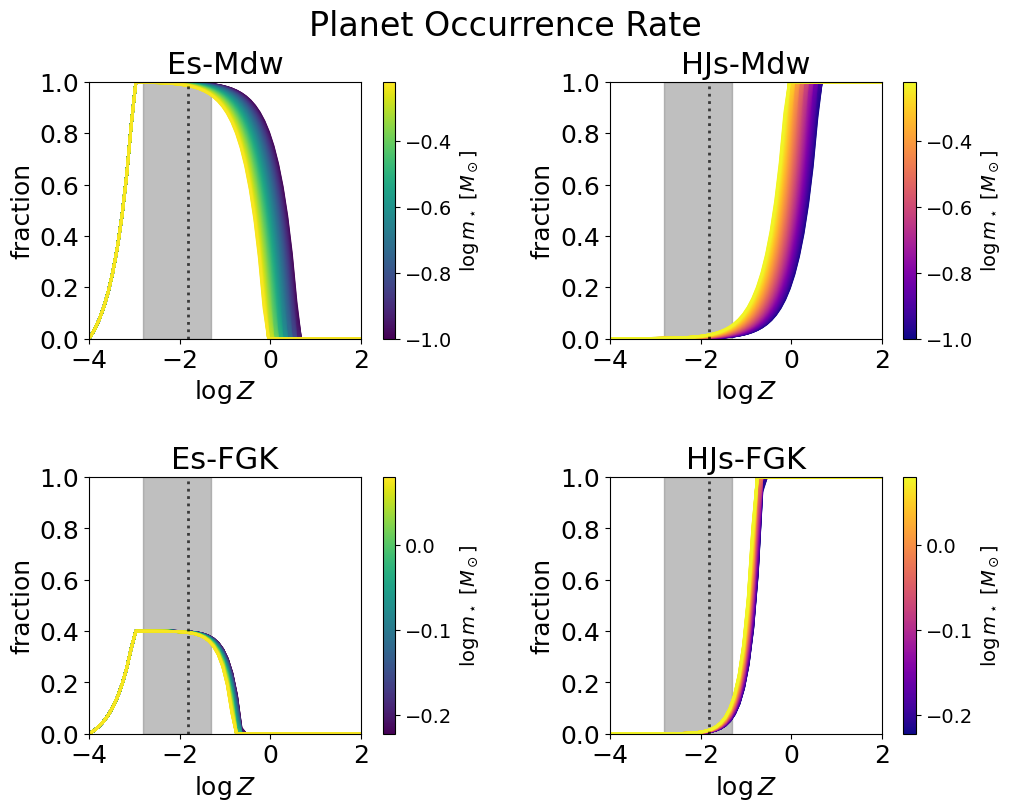

In [192]:
fig = plt.figure(figsize=(10,8), constrained_layout=True)
fig.suptitle("Planet Occurrence Rate", fontsize=24)

gs = GridSpec(2,2,figure=fig,wspace=0.1,hspace=0.1)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[0, 1])
ax4 = fig.add_subplot(gs[1, 1])

ax1.set(xlim=(-4.,2.), ylim=(0.,1.))
ax1.set_title('Es-Mdw',fontsize=22)
ax1.set_xlabel('$\\log Z$',fontsize=18.)
ax1.set_ylabel('fraction',fontsize=18.)
ax1.tick_params(axis='both', labelsize=18)

ax2.set(xlim=(-4.,2.), ylim=(0.,1.))
ax2.set_title('Es-FGK',fontsize=22)
ax2.set_xlabel('$\\log Z$',fontsize=18.)
ax2.set_ylabel('fraction',fontsize=18.)
ax2.tick_params(axis='both', labelsize=18)

ax3.set(xlim=(-4.,2.), ylim=(0.,1.))
ax3.set_title('HJs-Mdw',fontsize=22)
ax3.set_xlabel('$\\log Z$',fontsize=18.)
ax3.set_ylabel('fraction',fontsize=18.)
ax3.tick_params(axis='both', labelsize=18)

ax4.set(xlim=(-4.,2.), ylim=(0.,1.))
ax4.set_title('HJs-FGK',fontsize=22)
ax4.set_xlabel('$\\log Z$',fontsize=18.)
ax4.set_ylabel('fraction',fontsize=18.)
ax4.tick_params(axis='both', labelsize=18)


nmsref=100
mslogref_FGK=np.linspace(np.log10(msmin_FGK),np.log10(msmax_FGK),nmsref)
mslogref_Mdw=np.linspace(np.log10(msmin_Mdw),np.log10(msmax_Mdw),nmsref)

colors_terr = plt.cm.viridis(np.linspace(0,1,nmsref))
colors_jupy = plt.cm.plasma(np.linspace(0,1,nmsref))
for ims in range(1,nmsref-1):
    ax1.plot(zetalog,interp1d(mslog,prob_terr_Mdw,axis=1)(mslogref_Mdw[ims]),c=colors_terr[ims],ls='-',lw=2)
    ax2.plot(zetalog,interp1d(mslog,prob_terr_FGK,axis=1)(mslogref_FGK[ims]),c=colors_terr[ims],ls='-',lw=2)
    ax3.plot(zetalog,interp1d(mslog,prob_jupy_Mdw,axis=1)(mslogref_Mdw[ims]),c=colors_jupy[ims],ls='-',lw=2)
    ax4.plot(zetalog,interp1d(mslog,prob_jupy_FGK,axis=1)(mslogref_FGK[ims]),c=colors_jupy[ims],ls='-',lw=2)


ax1.vlines(np.log10(zeta_sun),ymin=0.,ymax=10,ls=':',lw=2,color='black',alpha=0.7)
ax2.vlines(np.log10(zeta_sun),ymin=0.,ymax=10,ls=':',lw=2,color='black',alpha=0.7)
ax3.vlines(np.log10(zeta_sun),ymin=0.,ymax=10,ls=':',lw=2,color='black',alpha=0.7)
ax4.vlines(np.log10(zeta_sun),ymin=0.,ymax=10,ls=':',lw=2,color='black',alpha=0.7)

ax1.fill_betweenx([0.,1.],-1.+np.log10(zeta_sun),0.5+np.log10(zeta_sun),alpha=0.5, color='grey')
ax2.fill_betweenx([0.,1.],-1.+np.log10(zeta_sun),0.5+np.log10(zeta_sun),alpha=0.5, color='grey')
ax3.fill_betweenx([0.,1.],-1.+np.log10(zeta_sun),0.5+np.log10(zeta_sun),alpha=0.5, color='grey')
ax4.fill_betweenx([0.,1.],-1.+np.log10(zeta_sun),0.5+np.log10(zeta_sun),alpha=0.5, color='grey')

norm_FGK = mpl.colors.Normalize(vmin=np.log10(msmin_FGK), vmax=np.log10(msmax_FGK))
norm_Mdw = mpl.colors.Normalize(vmin=np.log10(msmin_Mdw), vmax=np.log10(msmax_Mdw))

cmap = plt.get_cmap('viridis', nms)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_Mdw)
sm.set_array([])
cbar=plt.colorbar(sm,orientation='vertical',ax=ax1)
cbar.set_label('$\\log m_\\star$ [$M_\\odot$]', rotation=90,fontsize=14)
cbar.ax.tick_params(labelsize=14)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_FGK)
sm.set_array([])
cbar=plt.colorbar(sm,orientation='vertical',ax=ax2)
cbar.set_label('$\\log m_\\star$ [$M_\\odot$]', rotation=90,fontsize=14)
cbar.ax.tick_params(labelsize=14)

cmap = plt.get_cmap('plasma', nms)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_Mdw)
sm.set_array([])
cbar=plt.colorbar(sm,orientation='vertical',ax=ax3)
cbar.set_label('$\\log m_\\star$ [$M_\\odot$]', rotation=90,fontsize=14)
cbar.ax.tick_params(labelsize=14)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm_FGK)
sm.set_array([])
cbar=plt.colorbar(sm,orientation='vertical',ax=ax4)
cbar.set_label('$\\log m_\\star$ [$M_\\odot$]', rotation=90,fontsize=14)
cbar.ax.tick_params(labelsize=14)

#plt.savefig(path+'planetfrac_2D'.pdf')
plt.show()

### Stellar term: number of planets per stellar mass formed

In [193]:
imf_type='Chabrier'
#imf_type='Salpeter'
jstars_FGK=np.logical_and(mslog>=np.log10(msmin_FGK),mslog<=np.log10(msmax_FGK))
jstars_Mdw=np.logical_and(mslog>=np.log10(msmin_Mdw),mslog<=np.log10(msmax_Mdw))
# frac_stars_FGK=trapz(ms[jstars_FGK]*IMF(mslog[jstars_FGK],imf_type))/trapz(ms*IMF(mslog,imf_type))
# frac_stars_Mdw=trapz(ms[jstars_Mdw]*IMF(mslog[jstars_Mdw],imf_type))/trapz(ms*IMF(mslog,imf_type))
# msave_FGK=trapz(ms[jstars_FGK]**2.*IMF(mslog[jstars_FGK],imf_type))/trapz(ms[jstars_FGK]*IMF(mslog[jstars_FGK],imf_type))
# msave_Mdw=trapz(ms[jstars_Mdw]**2.*IMF(mslog[jstars_Mdw],imf_type))/trapz(ms[jstars_Mdw]*IMF(mslog[jstars_Mdw],imf_type))

num_jupy_zeta_FGK=trapz((ms[np.newaxis,:]*IMF(mslog[np.newaxis,:],imf_type)*zetalog[:,np.newaxis]/zetalog[:,np.newaxis])[:,jstars_FGK]*prob_jupy_FGK[:,jstars_FGK],mslog[jstars_FGK],axis=1)*np.log(10.)
num_jupy_zeta_Mdw=trapz((ms[np.newaxis,:]*IMF(mslog[np.newaxis,:],imf_type)*zetalog[:,np.newaxis]/zetalog[:,np.newaxis])[:,jstars_Mdw]*prob_jupy_Mdw[:,jstars_Mdw],mslog[jstars_Mdw],axis=1)*np.log(10.)

num_terr_zeta_FGK=trapz((ms[np.newaxis,:]*IMF(mslog[np.newaxis,:],imf_type)*zetalog[:,np.newaxis]/zetalog[:,np.newaxis])[:,jstars_FGK]*prob_terr_FGK[:,jstars_FGK],mslog[jstars_FGK],axis=1)*np.log(10.)
num_terr_zeta_Mdw=trapz((ms[np.newaxis,:]*IMF(mslog[np.newaxis,:],imf_type)*zetalog[:,np.newaxis]/zetalog[:,np.newaxis])[:,jstars_Mdw]*prob_terr_Mdw[:,jstars_Mdw],mslog[jstars_Mdw],axis=1)*np.log(10.)

num_zeta_star=trapz((ms[np.newaxis,:]*IMF(mslog[np.newaxis,:],imf_type)*zetalog[:,np.newaxis]/zetalog[:,np.newaxis]),mslog,axis=1)*np.log(10.)



### Planet formation rate

In [194]:

rho_star=trapz(rhosfr_zeta*num_zeta_star[:,np.newaxis],zetalog,axis=0)

rho_jupy_FGK=trapz(rhosfr_zeta*num_jupy_zeta_FGK[:,np.newaxis],zetalog,axis=0)
rho_jupy_Mdw=trapz(rhosfr_zeta*num_jupy_zeta_Mdw[:,np.newaxis],zetalog,axis=0)
rho_jupy=rho_jupy_Mdw+rho_jupy_FGK

rho_terr_FGK=trapz(rhosfr_zeta*num_terr_zeta_FGK[:,np.newaxis],zetalog,axis=0)
rho_terr_Mdw=trapz(rhosfr_zeta*num_terr_zeta_Mdw[:,np.newaxis],zetalog,axis=0)
rho_terr=rho_terr_Mdw+rho_terr_FGK


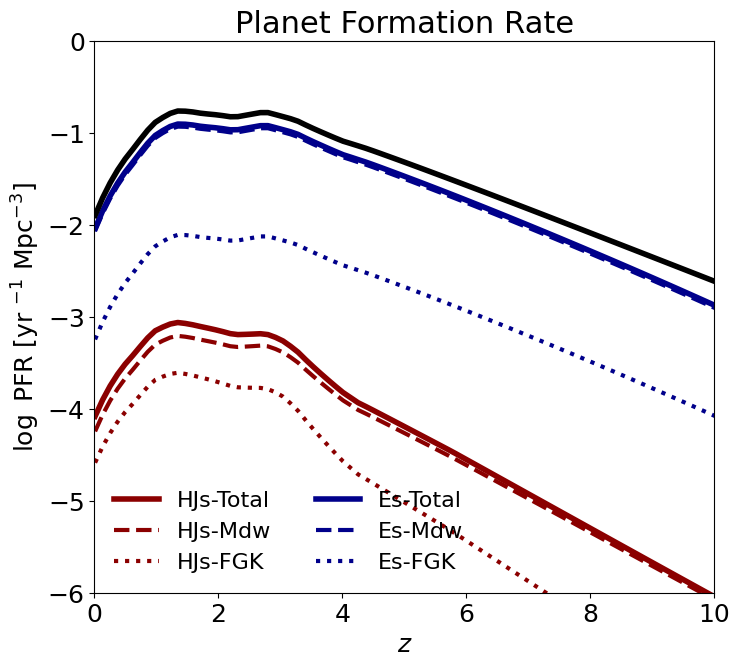

In [195]:
fig, ax=plt.subplots(figsize=(8,8))
fig.subplots_adjust(top=0.8)
ax.set(xlim=(0.,10.), ylim=(-6.,0.))
ax.set_title('Planet Formation Rate',fontsize=22)
ax.set_xlabel('$z$',fontsize=18.)
ax.set_ylabel('$\\log$ PFR [yr $^{-1}$ Mpc$^{-3}$]',fontsize=18.)
ax.tick_params(axis='both', labelsize=18)

ax.plot(z,np.log10(rho_jupy),c='darkred',ls='-',lw=4,label='HJs-Total')
ax.plot(z,np.log10(rho_jupy_Mdw),c='darkred',ls='--',lw=3,label='HJs-Mdw')
ax.plot(z,np.log10(rho_jupy_FGK),c='darkred',ls=':',lw=3,label='HJs-FGK')

ax.plot(z,np.log10(rho_terr),c='darkblue',ls='-',lw=4,label='Es-Total')
ax.plot(z,np.log10(rho_terr_Mdw),c='darkblue',ls='--',lw=3,label='Es-Mdw')
ax.plot(z,np.log10(rho_terr_FGK),c='darkblue',ls=':',lw=3,label='Es-FGK')

ax.plot(z,np.log10(rho_star),c='black',ls='-',lw=4)

ax.legend(loc='lower left',fontsize=16,frameon=False,ncol=2)

plt.savefig(path+'PFR.pdf')
plt.show()

In [196]:
rhocum_star=np.flip(cumtrapz(np.flip(rho_star*np.abs(cosmo.age(z, derivative=1))),-np.flip(z),axis=0, initial=0))*1.e9

rhocum_jupy_FGK=np.flip(cumtrapz(np.flip(rho_jupy_FGK*np.abs(cosmo.age(z, derivative=1))),-np.flip(z),axis=0, initial=0))*1.e9
rhocum_jupy_Mdw=np.flip(cumtrapz(np.flip(rho_jupy_Mdw*np.abs(cosmo.age(z, derivative=1))),-np.flip(z),axis=0, initial=0))*1.e9
rhocum_jupy=rhocum_jupy_Mdw+rhocum_jupy_FGK

rhocum_terr_FGK=np.flip(cumtrapz(np.flip(rho_terr_FGK*np.abs(cosmo.age(z, derivative=1))),-np.flip(z),axis=0, initial=0))*1.e9
rhocum_terr_Mdw=np.flip(cumtrapz(np.flip(rho_terr_Mdw*np.abs(cosmo.age(z, derivative=1))),-np.flip(z),axis=0, initial=0))*1.e9
rhocum_terr=rhocum_terr_Mdw+rhocum_terr_FGK


rhoint_star=cumtrapz(rhocum_star*np.gradient(cosmopy.comoving_volume(z),z),z,axis=0, initial=0)

rhoint_jupy_FGK=cumtrapz(rhocum_jupy_FGK*np.gradient(cosmopy.comoving_volume(z),z),z,axis=0, initial=0)
rhoint_jupy_Mdw=cumtrapz(rhocum_jupy_Mdw*np.gradient(cosmopy.comoving_volume(z),z),z,axis=0, initial=0)
rhoint_jupy=rhoint_jupy_Mdw+rhoint_jupy_FGK

rhoint_terr_FGK=cumtrapz(rhocum_terr_FGK*np.gradient(cosmopy.comoving_volume(z),z),z,axis=0, initial=0)
rhoint_terr_Mdw=cumtrapz(rhocum_terr_Mdw*np.gradient(cosmopy.comoving_volume(z),z),z,axis=0, initial=0)
rhoint_terr=rhoint_terr_Mdw+rhoint_terr_FGK


C:\Users\andre\AppData\Local\Temp\ipykernel_3644\631345844.py:9: RuntimeWarning: divide by zero encountered in log10
  ax.plot(z,np.log10(rhocum_jupy),c='darkred',ls='-',lw=4,label='HJs-Total')
C:\Users\andre\AppData\Local\Temp\ipykernel_3644\631345844.py:10: RuntimeWarning: divide by zero encountered in log10
  ax.plot(z,np.log10(rhocum_jupy_Mdw),c='darkred',ls='--',lw=3,label='HJs-Mdw')
C:\Users\andre\AppData\Local\Temp\ipykernel_3644\631345844.py:11: RuntimeWarning: divide by zero encountered in log10
  ax.plot(z,np.log10(rhocum_jupy_FGK),c='darkred',ls=':',lw=3,label='HJs-FGK')
C:\Users\andre\AppData\Local\Temp\ipykernel_3644\631345844.py:13: RuntimeWarning: divide by zero encountered in log10
  ax.plot(z,np.log10(rhocum_terr),c='darkblue',ls='-',lw=4,label='Es-Total')
C:\Users\andre\AppData\Local\Temp\ipykernel_3644\631345844.py:14: RuntimeWarning: divide by zero encountered in log10
  ax.plot(z,np.log10(rhocum_terr_Mdw),c='darkblue',ls='--',lw=3,label='Es-Mdw')
C:\Users\andre\App

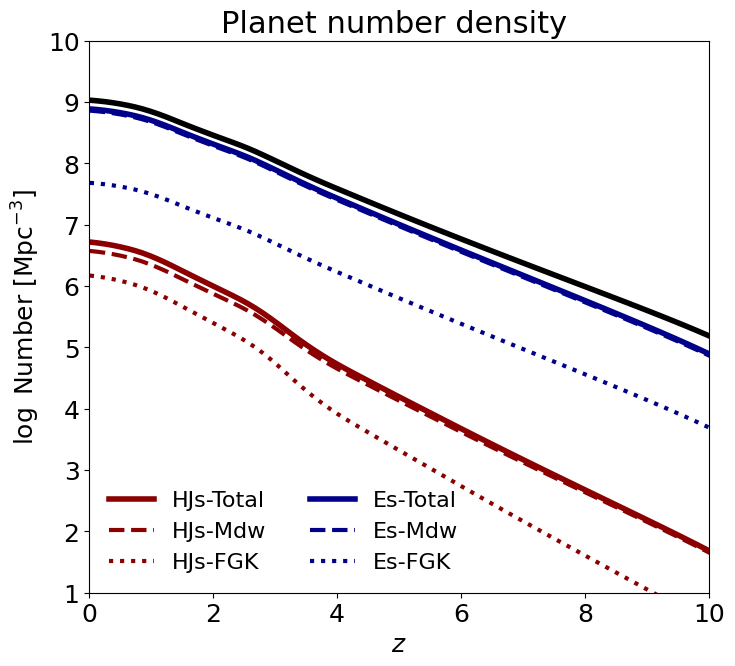

In [197]:
fig, ax=plt.subplots(figsize=(8,8))
fig.subplots_adjust(top=0.8)
ax.set(xlim=(0.,10.), ylim=(1.,10.))
ax.set_title('Planet number density ',fontsize=22)
ax.set_xlabel('$z$',fontsize=18.)
ax.set_ylabel('$\\log$ Number [Mpc$^{-3}$]',fontsize=18.)
ax.tick_params(axis='both', labelsize=18)

ax.plot(z,np.log10(rhocum_jupy),c='darkred',ls='-',lw=4,label='HJs-Total')
ax.plot(z,np.log10(rhocum_jupy_Mdw),c='darkred',ls='--',lw=3,label='HJs-Mdw')
ax.plot(z,np.log10(rhocum_jupy_FGK),c='darkred',ls=':',lw=3,label='HJs-FGK')

ax.plot(z,np.log10(rhocum_terr),c='darkblue',ls='-',lw=4,label='Es-Total')
ax.plot(z,np.log10(rhocum_terr_Mdw),c='darkblue',ls='--',lw=3,label='Es-Mdw')
ax.plot(z,np.log10(rhocum_terr_FGK),c='darkblue',ls=':',lw=3,label='Es-FGK')

ax.plot(z,np.log10(rhocum_star),c='black',ls='-',lw=4)

ax.legend(loc='lower left',fontsize=16,frameon=False,ncol=2)

plt.savefig(path+'PFRcum.pdf')
plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_3644\734117556.py:9: RuntimeWarning: divide by zero encountered in log10
  ax.plot(z,np.log10(rhoint_jupy),c='darkred',ls='-',lw=4,label='Js-Total')
C:\Users\andre\AppData\Local\Temp\ipykernel_3644\734117556.py:10: RuntimeWarning: divide by zero encountered in log10
  ax.plot(z,np.log10(rhoint_jupy_Mdw),c='darkred',ls='--',lw=3,label='Js-Mdw')
C:\Users\andre\AppData\Local\Temp\ipykernel_3644\734117556.py:11: RuntimeWarning: divide by zero encountered in log10
  ax.plot(z,np.log10(rhoint_jupy_FGK),c='darkred',ls=':',lw=3,label='Js-FGK')
C:\Users\andre\AppData\Local\Temp\ipykernel_3644\734117556.py:13: RuntimeWarning: divide by zero encountered in log10
  ax.plot(z,np.log10(rhoint_terr),c='darkblue',ls='-',lw=4,label='Es-Total')
C:\Users\andre\AppData\Local\Temp\ipykernel_3644\734117556.py:14: RuntimeWarning: divide by zero encountered in log10
  ax.plot(z,np.log10(rhoint_terr_Mdw),c='darkblue',ls='--',lw=3,label='Es-Mdw')
C:\Users\andre\AppDat

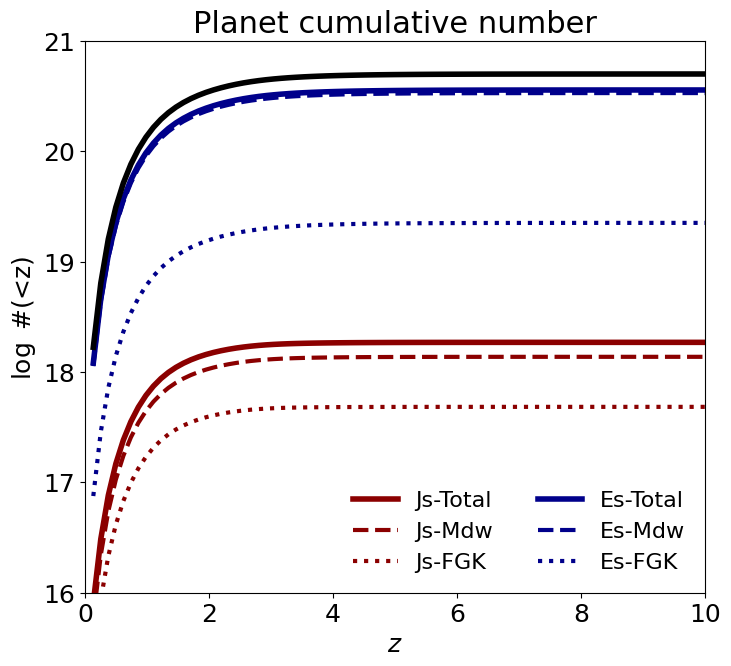

In [198]:
fig, ax=plt.subplots(figsize=(8,8))
fig.subplots_adjust(top=0.8)
ax.set(xlim=(0.,10.), ylim=(16.,21.))
ax.set_title('Planet cumulative number',fontsize=22)
ax.set_xlabel('$z$',fontsize=18.)
ax.set_ylabel('$\\log$ #(<z)',fontsize=18.)
ax.tick_params(axis='both', labelsize=18)

ax.plot(z,np.log10(rhoint_jupy),c='darkred',ls='-',lw=4,label='Js-Total')
ax.plot(z,np.log10(rhoint_jupy_Mdw),c='darkred',ls='--',lw=3,label='Js-Mdw')
ax.plot(z,np.log10(rhoint_jupy_FGK),c='darkred',ls=':',lw=3,label='Js-FGK')

ax.plot(z,np.log10(rhoint_terr),c='darkblue',ls='-',lw=4,label='Es-Total')
ax.plot(z,np.log10(rhoint_terr_Mdw),c='darkblue',ls='--',lw=3,label='Es-Mdw')
ax.plot(z,np.log10(rhoint_terr_FGK),c='darkblue',ls=':',lw=3,label='Es-FGK')

ax.plot(z,np.log10(rhoint_star),c='black',ls='-',lw=4)

ax.legend(loc='lower right',fontsize=16,frameon=False,ncol=2)

plt.savefig(path+'PFRcumnum.pdf')
plt.show()

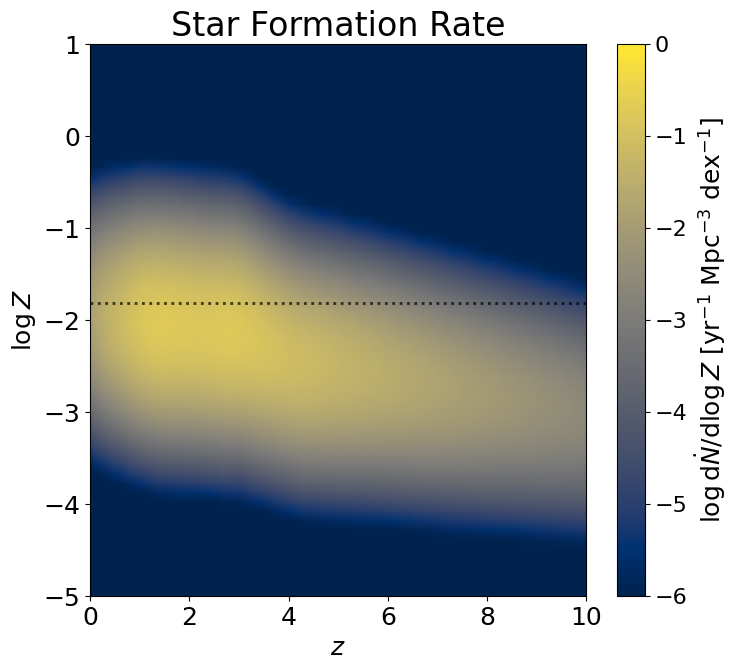

In [199]:
fig, ax=plt.subplots(figsize=(8,8))
fig.subplots_adjust(top=0.8)
ax.set(xlim=(0.,10.), ylim=(-5.,1.))
ax.set_title('Star Formation Rate',fontsize=24)
ax.set_xlabel('$z$',fontsize=18.)
ax.set_ylabel('$\\log Z$',fontsize=18.)
ax.tick_params(axis='both', labelsize=18)

X,Y=np.meshgrid(z,zetalog)
Z=np.log10(rhosfr_zeta*num_zeta_star[:,np.newaxis])
ax.pcolormesh(X,Y,Z,cmap="cividis",shading='gouraud',vmin=-6.,vmax=0.)
ax.hlines(np.log10(zeta_sun),xmin=0.,xmax=10.,ls=':',lw=2,color='black',alpha=0.7)

norm = mpl.colors.Normalize(vmin=-6., vmax=0.)
cmap = plt.get_cmap('cividis')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar=plt.colorbar(sm,orientation='vertical')
cbar.set_label('$\\log {\\rm d}\\dot N/{\\rm d}\\log Z$ [yr$^{-1}$ Mpc$^{-3}$ dex$^{-1}$]', rotation=90,fontsize=18)
cbar.ax.tick_params(labelsize=16)
plt.savefig(path+'SFR_2D.pdf')
plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_3644\2742826501.py:19: RuntimeWarning: divide by zero encountered in log10
  Z1=np.log10(rhosfr_zeta*(num_terr_zeta_Mdw[:,np.newaxis]+num_terr_zeta_FGK[:,np.newaxis]))
C:\Users\andre\AppData\Local\Temp\ipykernel_3644\2742826501.py:29: RuntimeWarning: divide by zero encountered in log10
  Z2=np.log10(rhosfr_zeta*(num_terr_zeta_Mdw[:,np.newaxis]))
C:\Users\andre\AppData\Local\Temp\ipykernel_3644\2742826501.py:39: RuntimeWarning: divide by zero encountered in log10
  Z3=np.log10(rhosfr_zeta*(num_terr_zeta_FGK[:,np.newaxis]))


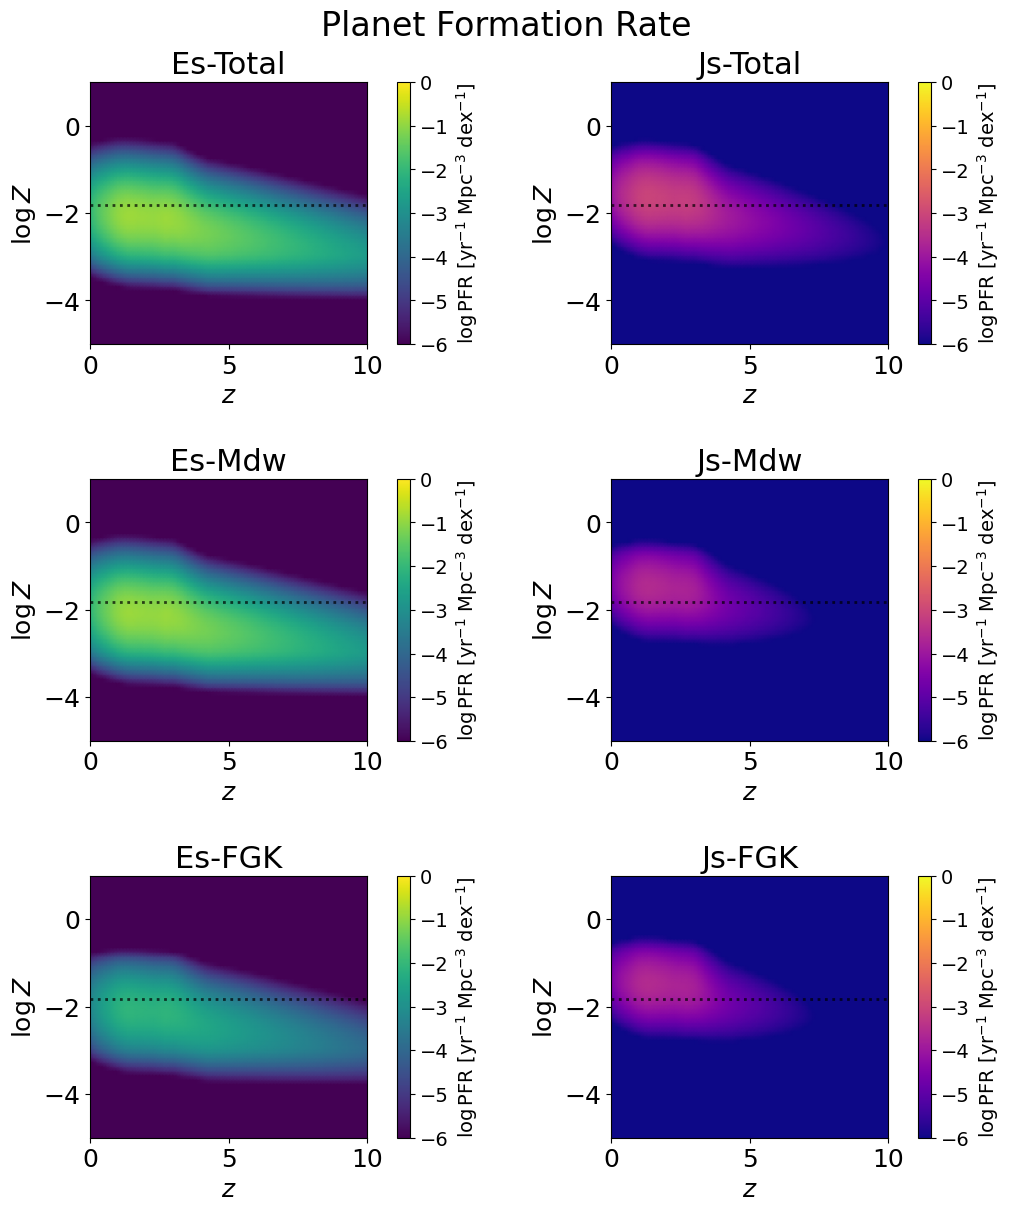

In [200]:
fig = plt.figure(figsize=(10,12), constrained_layout=True)
fig.suptitle("Planet Formation Rate", fontsize=24)

gs = GridSpec(3,2,figure=fig,wspace=0.1,hspace=0.1)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[0, 1])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[2, 1])

X,Y=np.meshgrid(z,zetalog)

ax1.set(xlim=(0.,10.), ylim=(-5.,1.))
ax1.set_title('Es-Total',fontsize=22)
ax1.set_xlabel('$z$',fontsize=18.)
ax1.set_ylabel('$\\log Z$',fontsize=18.)
ax1.tick_params(axis='both', labelsize=18)
Z1=np.log10(rhosfr_zeta*(num_terr_zeta_Mdw[:,np.newaxis]+num_terr_zeta_FGK[:,np.newaxis]))
Z1[np.isinf(Z1)]=-6.
ax1.pcolormesh(X,Y,Z1,cmap="viridis",shading='gouraud',vmin=-6.,vmax=0.)
ax1.hlines(np.log10(zeta_sun),xmin=0.,xmax=10.,ls=':',lw=2,color='black',alpha=0.7)

ax2.set(xlim=(0.,10.), ylim=(-5.,1.))
ax2.set_title('Es-Mdw',fontsize=22)
ax2.set_xlabel('$z$',fontsize=18.)
ax2.set_ylabel('$\\log Z$',fontsize=18.)
ax2.tick_params(axis='both', labelsize=18)
Z2=np.log10(rhosfr_zeta*(num_terr_zeta_Mdw[:,np.newaxis]))
Z2[np.isinf(Z2)]=-6.
ax2.pcolormesh(X,Y,Z2,cmap="viridis",shading='gouraud',vmin=-6.,vmax=0.)
ax2.hlines(np.log10(zeta_sun),xmin=0.,xmax=10.,ls=':',lw=2,color='black',alpha=0.7)

ax3.set(xlim=(0.,10.), ylim=(-5.,1.))
ax3.set_title('Es-FGK',fontsize=22)
ax3.set_xlabel('$z$',fontsize=18.)
ax3.set_ylabel('$\\log Z$',fontsize=18.)
ax3.tick_params(axis='both', labelsize=18)
Z3=np.log10(rhosfr_zeta*(num_terr_zeta_FGK[:,np.newaxis]))
Z3[np.isinf(Z3)]=-6.
ax3.pcolormesh(X,Y,Z3,cmap="viridis",shading='gouraud',vmin=-6.,vmax=0.)
ax3.hlines(np.log10(zeta_sun),xmin=0.,xmax=10.,ls=':',lw=2,color='black',alpha=0.7)

ax4.set(xlim=(0.,10.), ylim=(-5.,1.))
ax4.set_title('Js-Total',fontsize=22)
ax4.set_xlabel('$z$',fontsize=18.)
ax4.set_ylabel('$\\log Z$',fontsize=18.)
ax4.tick_params(axis='both', labelsize=18)
Z4=np.log10(rhosfr_zeta*(num_jupy_zeta_Mdw[:,np.newaxis]+num_jupy_zeta_FGK[:,np.newaxis]))
Z4[np.isinf(Z4)]=-6.
ax4.pcolormesh(X,Y,Z4,cmap="plasma",shading='gouraud',vmin=-6.,vmax=0.)
ax4.hlines(np.log10(zeta_sun),xmin=0.,xmax=10.,ls=':',lw=2,color='black',alpha=0.7)

ax5.set(xlim=(0.,10.), ylim=(-5.,1.))
ax5.set_title('Js-Mdw',fontsize=22)
ax5.set_xlabel('$z$',fontsize=18.)
ax5.set_ylabel('$\\log Z$',fontsize=18.)
ax5.tick_params(axis='both', labelsize=18)
Z5=np.log10(rhosfr_zeta*(num_jupy_zeta_FGK[:,np.newaxis]))
Z5[np.isinf(Z5)]=-6.
ax5.pcolormesh(X,Y,Z5,cmap="plasma",shading='gouraud',vmin=-6.,vmax=0.)
ax5.hlines(np.log10(zeta_sun),xmin=0.,xmax=10.,ls=':',lw=2,color='black',alpha=0.7)

ax6.set(xlim=(0.,10.), ylim=(-5.,1.))
ax6.set_title('Js-FGK',fontsize=22)
ax6.set_xlabel('$z$',fontsize=18.)
ax6.set_ylabel('$\\log Z$',fontsize=18.)
ax6.tick_params(axis='both', labelsize=18)
Z6=np.log10(rhosfr_zeta*(num_jupy_zeta_FGK[:,np.newaxis]))
Z6[np.isinf(Z6)]=-6.
ax6.pcolormesh(X,Y,Z6,cmap="plasma",shading='gouraud',vmin=-6.,vmax=0.)
ax6.hlines(np.log10(zeta_sun),xmin=0.,xmax=10.,ls=':',lw=2,color='black',alpha=0.7)

norm = mpl.colors.Normalize(vmin=-6., vmax=0.)

cmap = plt.get_cmap('viridis', nms)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar=plt.colorbar(sm,orientation='vertical',ax=ax1)
cbar.set_label('$\\log {\\rm PFR}$ [yr$^{-1}$ Mpc$^{-3}$ dex$^{-1}$]', rotation=90,fontsize=14)
cbar.ax.tick_params(labelsize=14)
cbar=plt.colorbar(sm,orientation='vertical',ax=ax2)
cbar.set_label('$\\log {\\rm PFR}$ [yr$^{-1}$ Mpc$^{-3}$ dex$^{-1}$]', rotation=90,fontsize=14)
cbar.ax.tick_params(labelsize=14)
cbar=plt.colorbar(sm,orientation='vertical',ax=ax3)
cbar.set_label('$\\log {\\rm PFR}$ [yr$^{-1}$ Mpc$^{-3}$ dex$^{-1}$]', rotation=90,fontsize=14)
cbar.ax.tick_params(labelsize=14)

cmap = plt.get_cmap('plasma', nms)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar=plt.colorbar(sm,orientation='vertical',ax=ax4)
cbar.set_label('$\\log {\\rm PFR}$ [yr$^{-1}$ Mpc$^{-3}$ dex$^{-1}$]', rotation=90,fontsize=14)
cbar.ax.tick_params(labelsize=14)
cbar=plt.colorbar(sm,orientation='vertical',ax=ax5)
cbar.set_label('$\\log {\\rm PFR}$ [yr$^{-1}$ Mpc$^{-3}$ dex$^{-1}$]', rotation=90,fontsize=14)
cbar.ax.tick_params(labelsize=14)
cbar=plt.colorbar(sm,orientation='vertical',ax=ax6)
cbar.set_label('$\\log {\\rm PFR}$ [yr$^{-1}$ Mpc$^{-3}$ dex$^{-1}$]', rotation=90,fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.savefig(path+'PFR_2D.pdf')
plt.show()

In [201]:
rhomstar_star=trapz(rhosfr_mstarzeta*num_zeta_star[np.newaxis,:,np.newaxis],zetalog,axis=1)

rhomstar_jupy_FGK=trapz(rhosfr_mstarzeta*num_jupy_zeta_FGK[np.newaxis,:,np.newaxis],zetalog,axis=1)
rhomstar_jupy_Mdw=trapz(rhosfr_mstarzeta*num_jupy_zeta_Mdw[np.newaxis,:,np.newaxis],zetalog,axis=1)
rhomstar_jupy=rho_jupy_Mdw+rho_jupy_FGK

rhomstar_terr_FGK=trapz(rhosfr_mstarzeta*num_terr_zeta_FGK[np.newaxis,:,np.newaxis],zetalog,axis=1)
rhomstar_terr_Mdw=trapz(rhosfr_mstarzeta*num_terr_zeta_Mdw[np.newaxis,:,np.newaxis],zetalog,axis=1)
rhomstar_terr=rho_terr_Mdw+rho_terr_FGK


C:\Users\andre\AppData\Local\Temp\ipykernel_3644\3837033447.py:10: RuntimeWarning: divide by zero encountered in log10
  Z=np.log10(rhomstar_star)


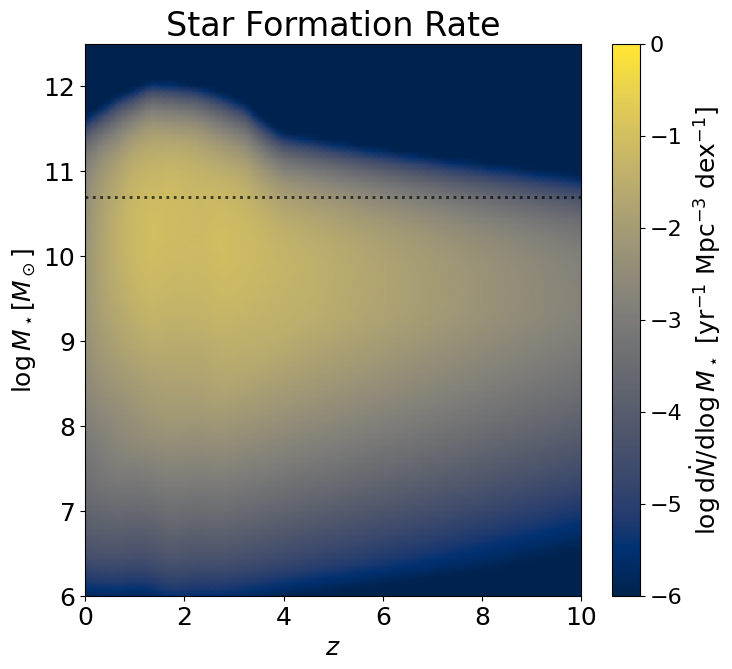

In [203]:
fig, ax=plt.subplots(figsize=(8,8))
fig.subplots_adjust(top=0.8)
ax.set(xlim=(0.,10.), ylim=(6.,12.5))
ax.set_title('Star Formation Rate',fontsize=24)
ax.set_xlabel('$z$',fontsize=18.)
ax.set_ylabel('$\\log M_\\star [M_\\odot]$',fontsize=18.)
ax.tick_params(axis='both', labelsize=18)

X,Y=np.meshgrid(z,mstarlog)
Z=np.log10(rhomstar_star)

#Z=np.log10(rhosfr_mstarpass)


ax.pcolormesh(X,Y,Z,cmap="cividis",shading='gouraud',vmin=-6.,vmax=0.)
mstar_MW=5.e10
ax.hlines(np.log10(mstar_MW),xmin=0.,xmax=10.,ls=':',lw=2,color='black',alpha=0.7)

norm = mpl.colors.Normalize(vmin=-6., vmax=0.)
cmap = plt.get_cmap('cividis')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar=plt.colorbar(sm,orientation='vertical')
cbar.set_label('$\\log {\\rm d}\\dot N/{\\rm d}\\log M_\\star$ [yr$^{-1}$ Mpc$^{-3}$ dex$^{-1}$]', rotation=90,fontsize=18)
cbar.ax.tick_params(labelsize=16)
#plt.savefig(path+'SFRmstar_2D.pdf')
plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_3644\2979853238.py:19: RuntimeWarning: divide by zero encountered in log10
  Z1=Z=np.log10(rhomstar_terr_Mdw+rhomstar_terr_FGK)
C:\Users\andre\AppData\Local\Temp\ipykernel_3644\2979853238.py:29: RuntimeWarning: divide by zero encountered in log10
  Z2=np.log10(rhomstar_terr_Mdw)
C:\Users\andre\AppData\Local\Temp\ipykernel_3644\2979853238.py:39: RuntimeWarning: divide by zero encountered in log10
  Z3=np.log10(rhomstar_terr_FGK)
C:\Users\andre\AppData\Local\Temp\ipykernel_3644\2979853238.py:49: RuntimeWarning: divide by zero encountered in log10
  Z4=np.log10(rhomstar_jupy_Mdw+rhomstar_jupy_FGK)
C:\Users\andre\AppData\Local\Temp\ipykernel_3644\2979853238.py:59: RuntimeWarning: divide by zero encountered in log10
  Z5=np.log10(rhomstar_jupy_Mdw)
C:\Users\andre\AppData\Local\Temp\ipykernel_3644\2979853238.py:69: RuntimeWarning: divide by zero encountered in log10
  Z6=np.log10(rhomstar_jupy_FGK)


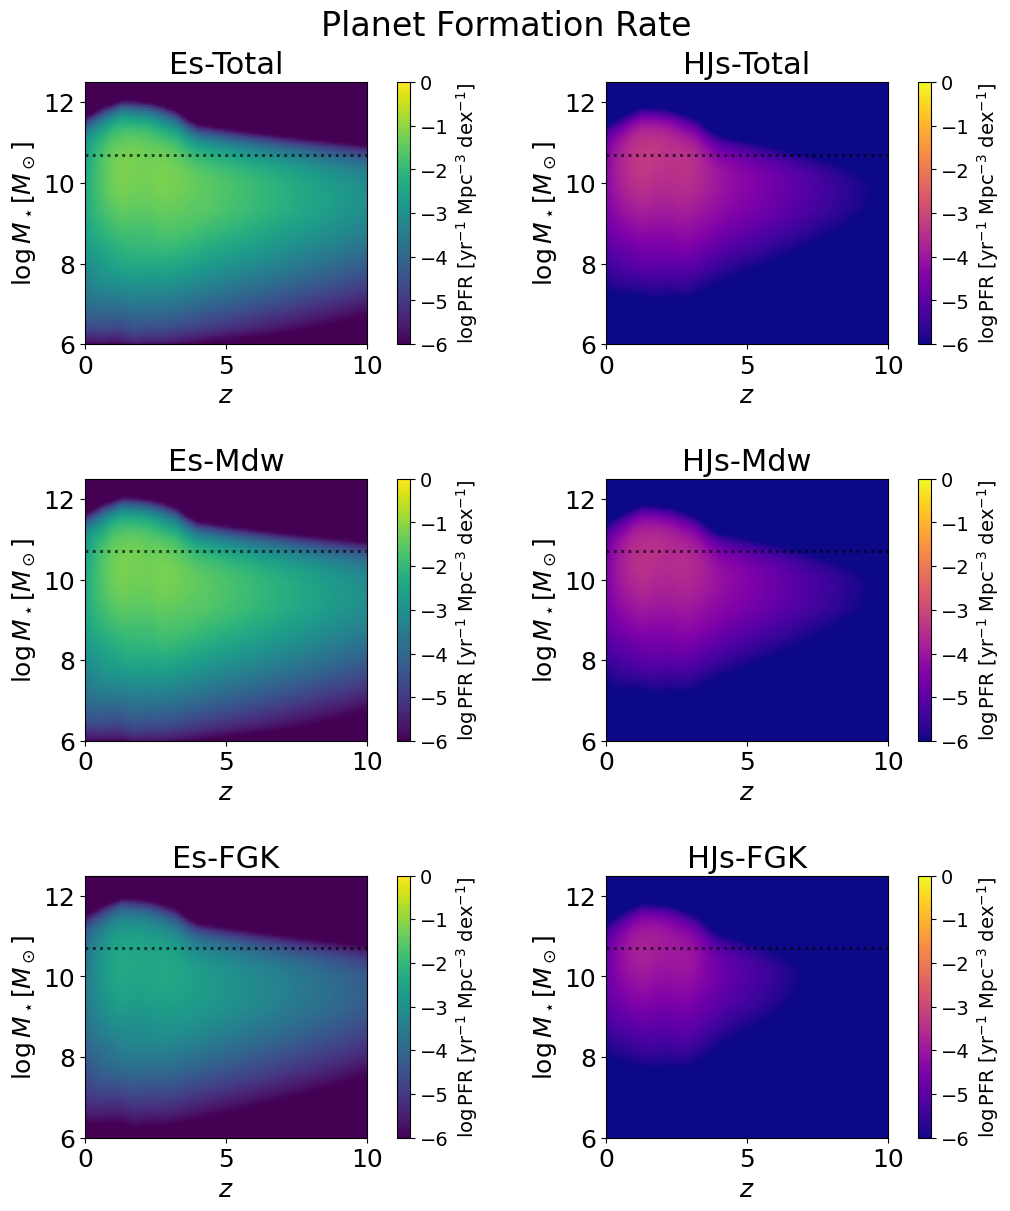

In [205]:
fig = plt.figure(figsize=(10,12), constrained_layout=True)
fig.suptitle("Planet Formation Rate", fontsize=24)

gs = GridSpec(3,2,figure=fig,wspace=0.1,hspace=0.1)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[0, 1])
ax5 = fig.add_subplot(gs[1, 1])
ax6 = fig.add_subplot(gs[2, 1])

X,Y=np.meshgrid(z,mstarlog)

ax1.set(xlim=(0.,10.), ylim=(6.,12.5))
ax1.set_title('Es-Total',fontsize=22)
ax1.set_xlabel('$z$',fontsize=18.)
ax1.set_ylabel('$\\log M_\\star [M_\\odot]$',fontsize=18.)
ax1.tick_params(axis='both', labelsize=18)
Z1=Z=np.log10(rhomstar_terr_Mdw+rhomstar_terr_FGK)
Z1[np.isinf(Z1)]=-6.
ax1.pcolormesh(X,Y,Z1,cmap="viridis",shading='gouraud',vmin=-6.,vmax=0.)
ax1.hlines(np.log10(mstar_MW),xmin=0.,xmax=10.,ls=':',lw=2,color='black',alpha=0.7)

ax2.set(xlim=(0.,10.), ylim=(6.,12.5))
ax2.set_title('Es-Mdw',fontsize=22)
ax2.set_xlabel('$z$',fontsize=18.)
ax2.set_ylabel('$\\log M_\\star [M_\\odot]$',fontsize=18.)
ax2.tick_params(axis='both', labelsize=18)
Z2=np.log10(rhomstar_terr_Mdw)
Z2[np.isinf(Z2)]=-6.
ax2.pcolormesh(X,Y,Z2,cmap="viridis",shading='gouraud',vmin=-6.,vmax=0.)
ax2.hlines(np.log10(mstar_MW),xmin=0.,xmax=10.,ls=':',lw=2,color='black',alpha=0.7)

ax3.set(xlim=(0.,10.), ylim=(6.,12.5))
ax3.set_title('Es-FGK',fontsize=22)
ax3.set_xlabel('$z$',fontsize=18.)
ax3.set_ylabel('$\\log M_\\star [M_\\odot]$',fontsize=18.)
ax3.tick_params(axis='both', labelsize=18)
Z3=np.log10(rhomstar_terr_FGK)
Z3[np.isinf(Z3)]=-6.
ax3.pcolormesh(X,Y,Z3,cmap="viridis",shading='gouraud',vmin=-6.,vmax=0.)
ax3.hlines(np.log10(mstar_MW),xmin=0.,xmax=10.,ls=':',lw=2,color='black',alpha=0.7)

ax4.set(xlim=(0.,10.), ylim=(6.,12.5))
ax4.set_title('HJs-Total',fontsize=22)
ax4.set_xlabel('$z$',fontsize=18.)
ax4.set_ylabel('$\\log M_\\star [M_\\odot]$',fontsize=18.)
ax4.tick_params(axis='both', labelsize=18)
Z4=np.log10(rhomstar_jupy_Mdw+rhomstar_jupy_FGK)
Z4[np.isinf(Z4)]=-6.
ax4.pcolormesh(X,Y,Z4,cmap="plasma",shading='gouraud',vmin=-6.,vmax=0.)
ax4.hlines(np.log10(mstar_MW),xmin=0.,xmax=10.,ls=':',lw=2,color='black',alpha=0.7)

ax5.set(xlim=(0.,10.), ylim=(6.,12.5))
ax5.set_title('HJs-Mdw',fontsize=22)
ax5.set_xlabel('$z$',fontsize=18.)
ax5.set_ylabel('$\\log M_\\star [M_\\odot]$',fontsize=18.)
ax5.tick_params(axis='both', labelsize=18)
Z5=np.log10(rhomstar_jupy_Mdw)
Z5[np.isinf(Z5)]=-6.
ax5.pcolormesh(X,Y,Z5,cmap="plasma",shading='gouraud',vmin=-6.,vmax=0.)
ax5.hlines(np.log10(mstar_MW),xmin=0.,xmax=10.,ls=':',lw=2,color='black',alpha=0.7)

ax6.set(xlim=(0.,10.), ylim=(6.,12.5))
ax6.set_title('HJs-FGK',fontsize=22)
ax6.set_xlabel('$z$',fontsize=18.)
ax6.set_ylabel('$\\log M_\\star [M_\\odot]$',fontsize=18.)
ax6.tick_params(axis='both', labelsize=18)
Z6=np.log10(rhomstar_jupy_FGK)
Z6[np.isinf(Z6)]=-6.
ax6.pcolormesh(X,Y,Z6,cmap="plasma",shading='gouraud',vmin=-6.,vmax=0.)
ax6.hlines(np.log10(mstar_MW),xmin=0.,xmax=10.,ls=':',lw=2,color='black',alpha=0.7)

norm = mpl.colors.Normalize(vmin=-6., vmax=0.)

cmap = plt.get_cmap('viridis', nms)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar=plt.colorbar(sm,orientation='vertical',ax=ax1)
cbar.set_label('$\\log {\\rm PFR}$ [yr$^{-1}$ Mpc$^{-3}$ dex$^{-1}$]', rotation=90,fontsize=14)
cbar.ax.tick_params(labelsize=14)
cbar=plt.colorbar(sm,orientation='vertical',ax=ax2)
cbar.set_label('$\\log {\\rm PFR}$ [yr$^{-1}$ Mpc$^{-3}$ dex$^{-1}$]', rotation=90,fontsize=14)
cbar.ax.tick_params(labelsize=14)
cbar=plt.colorbar(sm,orientation='vertical',ax=ax3)
cbar.set_label('$\\log {\\rm PFR}$ [yr$^{-1}$ Mpc$^{-3}$ dex$^{-1}$]', rotation=90,fontsize=14)
cbar.ax.tick_params(labelsize=14)

cmap = plt.get_cmap('plasma', nms)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar=plt.colorbar(sm,orientation='vertical',ax=ax4)
cbar.set_label('$\\log {\\rm PFR}$ [yr$^{-1}$ Mpc$^{-3}$ dex$^{-1}$]', rotation=90,fontsize=14)
cbar.ax.tick_params(labelsize=14)
cbar=plt.colorbar(sm,orientation='vertical',ax=ax5)
cbar.set_label('$\\log {\\rm PFR}$ [yr$^{-1}$ Mpc$^{-3}$ dex$^{-1}$]', rotation=90,fontsize=14)
cbar.ax.tick_params(labelsize=14)
cbar=plt.colorbar(sm,orientation='vertical',ax=ax6)
cbar.set_label('$\\log {\\rm PFR}$ [yr$^{-1}$ Mpc$^{-3}$ dex$^{-1}$]', rotation=90,fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.savefig(path+'PFR_2D.pdf')
plt.show()

#### Habitability

In [206]:
frac_habterr_FGK=0.04 # excluding super-earths  
num_habterr_zeta=num_terr_zeta_FGK*frac_habterr_FGK/frac_terr_FGK # only conservatively considering FGK stars (M-dw can be critical for various reasons)

fluxthr=1.e8 # cgs  100 kJ/m^2 Gehrels+03

# threatening effects of type II SNe
msmin_snii = 8.
msmax_snii = 60.
rthr_snii = np.sqrt(1.e48/4./np.pi/fluxthr)/3.e24 # Mpc
jsnii=np.logical_and(mslog>np.log10(msmin_snii),mslog<np.log10(msmax_snii)) 

# threatening effects of type Ia SNe
msmin_snia = 3.
msmax_snia = 8.
rthr_snia = np.sqrt(1.e49/4./np.pi/fluxthr)/3.e24 # Mpc
jsnia=np.logical_and(mslog>np.log10(msmin_snia),mslog<np.log10(msmax_snia)) 
norm_snia=0.01

# threatening effects of LGRBs
msmin_lgrb = 20.
msmax_lgrb = 60.
rthr_lgrb = np.sqrt(1.e52/4./np.pi/fluxthr)/3.e24 # Mpc
jlgrb=np.logical_and(mslog>np.log10(msmin_lgrb),mslog<np.log10(msmax_lgrb)) 
norm_lgrb=0.1
zetamax_lgrb=zeta_sun/5.
jzeta_lgrb=zeta>zetamax_lgrb

temp_snii=np.zeros(nzeta)
#temp_snia=np.zeros(nzeta)
temp_lgrb=np.zeros(nzeta)
for izeta in range(nzeta):
    temp_snii[izeta]= trapz(ms[jsnii]*IMF(mslog[jsnii],imf_type)*agems(mslog[jsnii],zetalog[izeta]),mslog[jsnii],axis=0)*np.log(10.) 
#    temp_snia[izeta]= norm_snia*trapz(ms[jsnia]*IMF(mslog[jsnia],imf_type)*5.e9,mslog[jsnia],axis=0)*np.log(10.) 
    temp_lgrb[izeta]= norm_lgrb*trapz(ms[jlgrb]*IMF(mslog[jlgrb],imf_type)*agems(mslog[jlgrb],zetalog[izeta]),mslog[jlgrb],axis=0)*np.log(10.) 
temp_lgrb[jzeta_lgrb]=0.


In [207]:
rho_habterr_zeta=np.zeros((nzeta,nz))
rho_habterr_zeta_snii=np.zeros((nzeta,nz))
rho_habterr_zeta_snia=np.zeros((nzeta,nz))
rho_habterr_zeta_lgrb=np.zeros((nzeta,nz))
rho_habterr_zeta_agn=np.zeros((nzeta,nz))
rho_habterr_mstarzeta=np.zeros((nmstar,nzeta,nz))
for iz in range(nz):
    sfrlog_MS=MS(mstarlog[:,np.newaxis,np.newaxis],z[iz])
    sfrlog_SB=sfrlog_MS+offset_SB
    norm_SB=frac_SB(mstarlog[:,np.newaxis,np.newaxis],z[iz])
    norm_MS=1.-norm_SB
    prob_sfr=(norm_MS*np.exp(-(sfrlog[np.newaxis,:,np.newaxis]-sfrlog_MS)**2./2./sigma_MS**2.)/np.sqrt(2.*np.pi*sigma_MS**2.)+norm_SB*np.exp(-(sfrlog[np.newaxis,:,np.newaxis]-sfrlog_SB)**2./2./sigma_SB**2.)/np.sqrt(2.*np.pi*sigma_SB**2.))*zetalog[np.newaxis,np.newaxis,:]/zetalog[np.newaxis,np.newaxis,:]
    zetalog_FMR=FMR(mstarlog[:,np.newaxis,np.newaxis],sfrlog[np.newaxis,:,np.newaxis],z[iz],kind)*zetalog[np.newaxis,np.newaxis,:]/zetalog[np.newaxis,np.newaxis,:]        
    prob_zeta=np.exp(-(zetalog[np.newaxis,np.newaxis,:]-zetalog_FMR)**2./2./sigma_FMR**2.)/np.sqrt(2.*np.pi*sigma_FMR**2.)
    
    fVthr_snii = temp_snii[np.newaxis,np.newaxis,:]*sfr[np.newaxis,:,np.newaxis]*4.*np.pi/3.*rthr_snii**3./mstar[:,np.newaxis,np.newaxis]*cosmo.rho_c(z[iz])*1.e9*200.
    fVthr_snii[fVthr_snii >1]=1. 
    fVthr_snii[fVthr_snii <0.]=0.    

    temp_snia=norm_snia*trapz(ms[jsnia]*IMF(mslog[jsnia],imf_type)*cosmo.age(z[iz])*1.e9/np.log(cosmo.age(0.)*1.e9/40.e6),mslog[jsnia],axis=0)*np.log(10.)*zetalog/zetalog
#    temp_snia=trapz(ms[jsnia]*IMF(mslog[jsnia],imf_type)*5.e8,mslog[jsnia],axis=0)*np.log(10.)*zetalog/zetalog
    fVthr_snia=temp_snia[np.newaxis,np.newaxis,:]*sfr[np.newaxis,:,np.newaxis]*4.*np.pi/3.*rthr_snia**3./mstar[:,np.newaxis,np.newaxis]*cosmo.rho_c(z[iz])*1.e9*200.
    fVthr_snia[fVthr_snia >1]=1.  
    fVthr_snia[fVthr_snia <0.]=0.   

    fVthr_lgrb = temp_lgrb[np.newaxis,np.newaxis,:]*sfr[np.newaxis,:,np.newaxis]*4.*np.pi/3.*rthr_lgrb**3./mstar[:,np.newaxis,np.newaxis]*cosmo.rho_c(z[iz])*1.e9*200.
    fVthr_lgrb[fVthr_lgrb >1]=1. 
    fVthr_lgrb[fVthr_lgrb <0.]=0.  

    # threatening effects of AGNs
    rthr_agn=10.**(-6.1+0.7*mstarlog[:,np.newaxis,np.newaxis])*1.e-3 #Mpc
#    rthr_agn=np.sqrt(1.38e38*0.3*2.e-3*mstar[:,np.newaxis,np.newaxis]*5.e7*3.15e7*0.7/4./np.pi/fluxthr)/3.e24
    fVthr_agn = 4.*np.pi/3.*rthr_agn**3./mstar[:,np.newaxis,np.newaxis]*cosmo.rho_c(z[iz])*1.e9*200.
    fVthr_agn[fVthr_agn >1]=1. 
    fVthr_agn[fVthr_agn <0.]=0.  

    temp1=trapz(prob_zeta*prob_sfr*sfr[np.newaxis,:,np.newaxis]*(1.-fVthr_snii)*(1.-fVthr_snia)*(1.-fVthr_lgrb)*(1.-fVthr_agn)*num_habterr_zeta[np.newaxis,np.newaxis,:],sfrlog,axis=1)
    temp2=trapz((10.**SMF(mstarlog,z[iz],'active'))[:,np.newaxis]*temp1,mstarlog,axis=0)

    temp1_snii=trapz(prob_zeta*prob_sfr*sfr[np.newaxis,:,np.newaxis]*(1.-fVthr_snii)*num_habterr_zeta[np.newaxis,np.newaxis,:],sfrlog,axis=1)
    temp2_snii=trapz((10.**SMF(mstarlog,z[iz],'active'))[:,np.newaxis]*temp1_snii,mstarlog,axis=0)

    temp1_snia=trapz(prob_zeta*prob_sfr*sfr[np.newaxis,:,np.newaxis]*(1.-fVthr_snia)*num_habterr_zeta[np.newaxis,np.newaxis,:],sfrlog,axis=1)
    temp2_snia=trapz((10.**SMF(mstarlog,z[iz],'active'))[:,np.newaxis]*temp1_snia,mstarlog,axis=0)

    temp1_lgrb=trapz(prob_zeta*prob_sfr*sfr[np.newaxis,:,np.newaxis]*(1.-fVthr_lgrb)*num_habterr_zeta[np.newaxis,np.newaxis,:],sfrlog,axis=1)
    temp2_lgrb=trapz((10.**SMF(mstarlog,z[iz],'active'))[:,np.newaxis]*temp1_lgrb,mstarlog,axis=0)

    temp1_agn=trapz(prob_zeta*prob_sfr*sfr[np.newaxis,:,np.newaxis]*(1.-fVthr_agn)*num_habterr_zeta[np.newaxis,np.newaxis,:],sfrlog,axis=1)
    temp2_agn=trapz((10.**SMF(mstarlog,z[iz],'active'))[:,np.newaxis]*temp1_agn,mstarlog,axis=0)

    rho_habterr_mstarzeta[:,:,iz]=(10.**SMF(mstarlog,z[iz],'active'))[:,np.newaxis]*temp1
    rho_habterr_zeta[:,iz]=temp2
    rho_habterr_zeta_snii[:,iz]=temp2_snii
    rho_habterr_zeta_snia[:,iz]=temp2_snia
    rho_habterr_zeta_lgrb[:,iz]=temp2_lgrb
    rho_habterr_zeta_agn[:,iz]=temp2_agn

rho_habterr_snii=trapz(rho_habterr_zeta_snii,zetalog,axis=0)
rho_habterr_snia=trapz(rho_habterr_zeta_snia,zetalog,axis=0)
rho_habterr_lgrb=trapz(rho_habterr_zeta_lgrb,zetalog,axis=0)
rho_habterr_agn=trapz(rho_habterr_zeta_agn,zetalog,axis=0)
rho_habterr=trapz(rho_habterr_zeta,zetalog,axis=0)


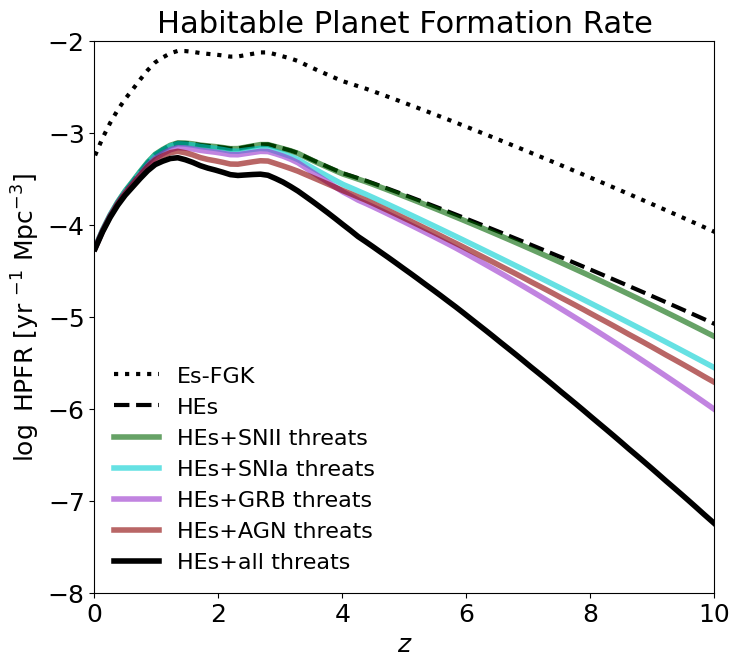

In [208]:
fig, ax=plt.subplots(figsize=(8,8))
fig.subplots_adjust(top=0.8)
ax.set(xlim=(0.,10.), ylim=(-8.,-2.))
ax.set_title('Habitable Planet Formation Rate',fontsize=22)
ax.set_xlabel('$z$',fontsize=18.)
ax.set_ylabel('$\\log$ HPFR [yr $^{-1}$ Mpc$^{-3}$]',fontsize=18.)
ax.tick_params(axis='both', labelsize=18)

ax.plot(z,np.log10(rho_terr_FGK),c='black',ls=':',lw=3,label='Es-FGK')
ax.plot(z,np.log10(rho_terr_FGK*frac_habterr_FGK/frac_terr_FGK),c='black',ls='--',lw=3,label='HEs')

ax.plot(z,np.log10(rho_habterr_snii),c='darkgreen',ls='-',lw=4,label='HEs+SNII threats',alpha=0.6)
ax.plot(z,np.log10(rho_habterr_snia),c='darkturquoise',ls='-',lw=4,label='HEs+SNIa threats',alpha=0.6)
ax.plot(z,np.log10(rho_habterr_lgrb),c='darkorchid',ls='-',lw=4,label='HEs+GRB threats',alpha=0.6)
ax.plot(z,np.log10(rho_habterr_agn),c='darkred',ls='-',lw=4,label='HEs+AGN threats',alpha=0.6)
ax.plot(z,np.log10(rho_habterr),c='black',ls='-',lw=4,label='HEs+all threats')

ax.legend(loc='lower left',fontsize=16,frameon=False,ncol=1)

plt.savefig(path+'HPFR.pdf')
plt.show()

In [209]:
rhocum_habterr=np.flip(cumtrapz(np.flip(rho_habterr*np.abs(cosmo.age(z, derivative=1))),-np.flip(z),axis=0, initial=0))*1.e9
rhoint_habterr=cumtrapz(rhocum_habterr*np.gradient(cosmopy.comoving_volume(z),z),z,axis=0, initial=0)

# older than earth
jold=cosmo.age(z)> cosmo.age(0.)-4.5
rho_habterr_old=trapz(rho_habterr_zeta,zetalog,axis=0)
rho_habterr_old[jold]=0.
rhocum_habterr_old=np.flip(cumtrapz(np.flip(rho_habterr_old*np.abs(cosmo.age(z, derivative=1))),-np.flip(z),axis=0, initial=0))*1.e9
rhoint_habterr_old=cumtrapz(rhocum_habterr_old*np.gradient(cosmopy.comoving_volume(z),z),z,axis=0, initial=0)



C:\Users\andre\AppData\Local\Temp\ipykernel_3644\80913636.py:9: RuntimeWarning: divide by zero encountered in log10
  ax.plot(z,np.log10(rhoint_terr_FGK),c='darkgrey',ls='--',lw=4,label='Es-FGK')
C:\Users\andre\AppData\Local\Temp\ipykernel_3644\80913636.py:11: RuntimeWarning: divide by zero encountered in log10
  ax.plot(z,np.log10(rhoint_terr_FGK*frac_habterr_FGK/frac_terr_FGK),c='darkblue',ls='-',lw=4,label='HEs')
C:\Users\andre\AppData\Local\Temp\ipykernel_3644\80913636.py:12: RuntimeWarning: divide by zero encountered in log10
  ax.plot(z,np.log10(rhoint_habterr),c='darkgreen',ls='-',lw=4,label='HEs+all threats')
C:\Users\andre\AppData\Local\Temp\ipykernel_3644\80913636.py:18: RuntimeWarning: divide by zero encountered in log10
  ax.plot(z[jj],np.log10(rhoint_habterr_old[jj]*(1.-fracsfr_pass[jj])),c='darkturquoise',ls='-',lw=4,label='HEs+all threats, age > 4.5 Gyr in SF @ z$\\sim$ 0')


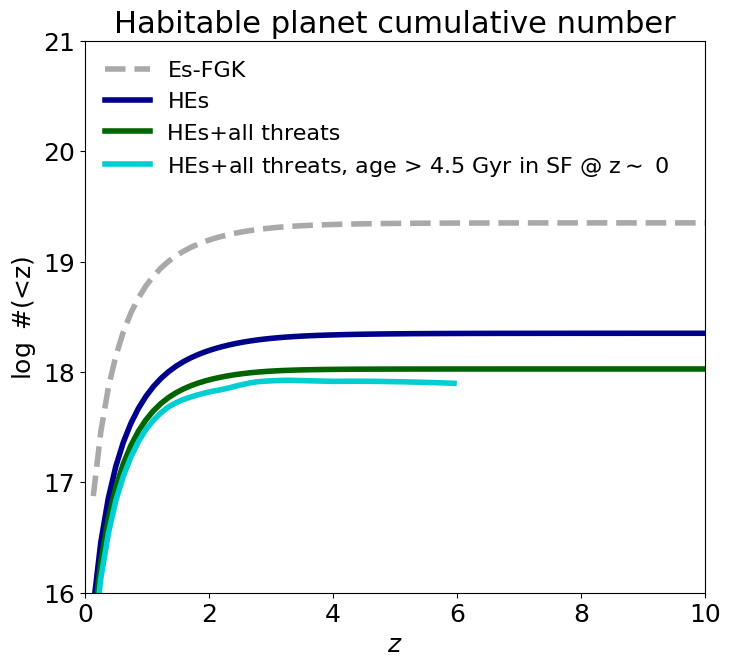

In [210]:
fig, ax=plt.subplots(figsize=(8,8))
fig.subplots_adjust(top=0.8)
ax.set(xlim=(0.,10.), ylim=(16.,21.))
ax.set_title('Habitable planet cumulative number',fontsize=22)
ax.set_xlabel('$z$',fontsize=18.)
ax.set_ylabel('$\\log$ #(<z)',fontsize=18.)
ax.tick_params(axis='both', labelsize=18)

ax.plot(z,np.log10(rhoint_terr_FGK),c='darkgrey',ls='--',lw=4,label='Es-FGK')

ax.plot(z,np.log10(rhoint_terr_FGK*frac_habterr_FGK/frac_terr_FGK),c='darkblue',ls='-',lw=4,label='HEs')
ax.plot(z,np.log10(rhoint_habterr),c='darkgreen',ls='-',lw=4,label='HEs+all threats')


#ax.plot(z,np.log10(rhoint_habterr_old),c='darkorange',ls='-',lw=4,label='HEs+all threats, age > 4.5 Gyr')

jj=z<6.
ax.plot(z[jj],np.log10(rhoint_habterr_old[jj]*(1.-fracsfr_pass[jj])),c='darkturquoise',ls='-',lw=4,label='HEs+all threats, age > 4.5 Gyr in SF @ z$\\sim$ 0')

ax.legend(loc='upper left',fontsize=16,frameon=False,ncol=1)

#plt.savefig(path+'PFRcumnum.pdf')
plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_3644\1720993126.py:16: RuntimeWarning: divide by zero encountered in log10
  Z1=np.log10(rhosfr_zeta*(num_terr_zeta_FGK[:,np.newaxis])*frac_habterr_FGK/frac_terr_FGK)
C:\Users\andre\AppData\Local\Temp\ipykernel_3644\1720993126.py:29: RuntimeWarning: divide by zero encountered in log10
  Z2=np.log10(rhomstar_terr_FGK*frac_habterr_FGK/frac_terr_FGK)
C:\Users\andre\AppData\Local\Temp\ipykernel_3644\1720993126.py:41: RuntimeWarning: divide by zero encountered in log10
  Z3=np.log10(rho_habterr_zeta)
C:\Users\andre\AppData\Local\Temp\ipykernel_3644\1720993126.py:54: RuntimeWarning: divide by zero encountered in log10
  Z4=np.log10(rhomstar_habterr)


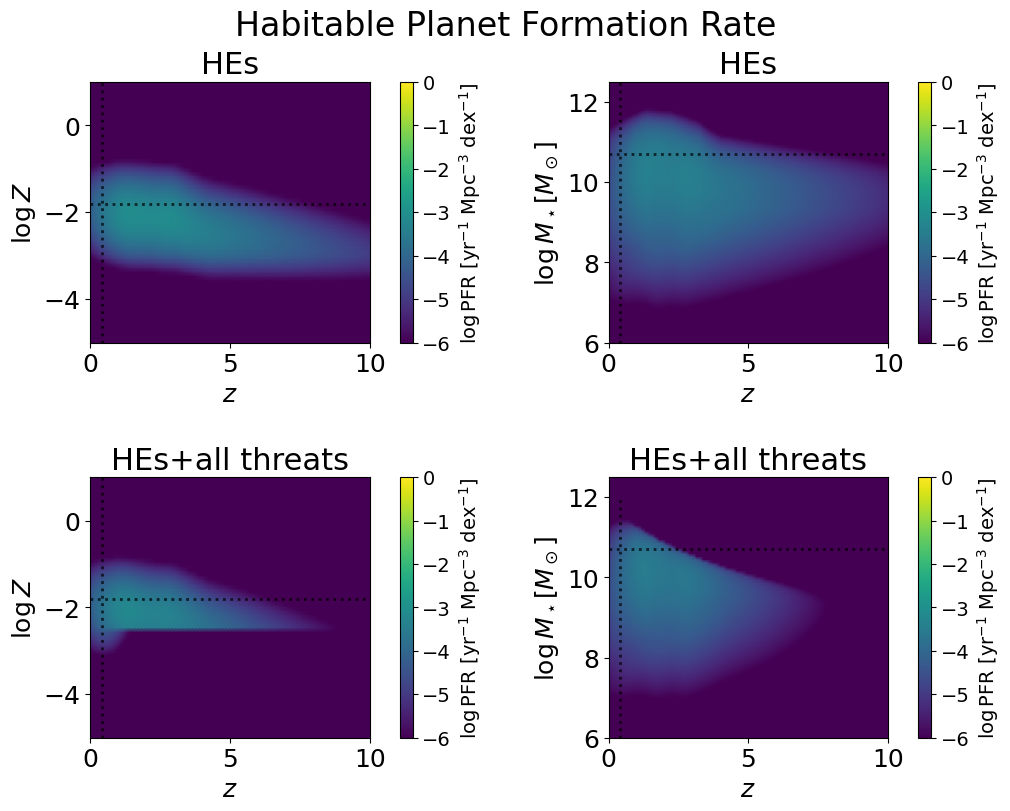

In [211]:
fig = plt.figure(figsize=(10,8), constrained_layout=True)
fig.suptitle("Habitable Planet Formation Rate", fontsize=24)

gs = GridSpec(2,2,figure=fig,wspace=0.1,hspace=0.1)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

ax1.set(xlim=(0.,10.), ylim=(-5.,1.))
ax1.set_title('HEs',fontsize=22)
ax1.set_xlabel('$z$',fontsize=18.)
ax1.set_ylabel('$\\log Z$',fontsize=18.)
ax1.tick_params(axis='both', labelsize=18)
X1,Y1=np.meshgrid(z,zetalog)
Z1=np.log10(rhosfr_zeta*(num_terr_zeta_FGK[:,np.newaxis])*frac_habterr_FGK/frac_terr_FGK)
Z1[np.isinf(Z1)]=-6.
ax1.pcolormesh(X1,Y1,Z1,cmap="viridis",shading='gouraud',vmin=-6.,vmax=0.)
ax1.hlines(np.log10(zeta_sun),xmin=0.,xmax=10.,ls=':',lw=2,color='black',alpha=0.7)
ax1.vlines(cosmo.age(cosmo.age(0.)-4.5,inverse=True),ymin=-5.,ymax=1.,ls=':',lw=2,color='black',alpha=0.7)

rhomstar_habterr=trapz(rho_habterr_mstarzeta,zetalog,axis=1)
ax2.set(xlim=(0.,10.), ylim=(6.,12.5))
ax2.set_title('HEs',fontsize=22)
ax2.set_xlabel('$z$',fontsize=18.)
ax2.set_ylabel('$\\log M_\\star [M_\\odot]$',fontsize=18.)
ax2.tick_params(axis='both', labelsize=18)
X2,Y2=np.meshgrid(z,mstarlog)
Z2=np.log10(rhomstar_terr_FGK*frac_habterr_FGK/frac_terr_FGK)
Z2[np.isinf(Z2)]=-6.
ax2.pcolormesh(X2,Y2,Z2,cmap="viridis",shading='gouraud',vmin=-6.,vmax=0.)
ax2.hlines(np.log10(mstar_MW),xmin=0.,xmax=10.,ls=':',lw=2,color='black',alpha=0.7)
ax2.vlines(cosmo.age(cosmo.age(0.)-4.5,inverse=True),ymin=6.,ymax=12.5,ls=':',lw=2,color='black',alpha=0.7)

ax3.set(xlim=(0.,10.), ylim=(-5.,1.))
ax3.set_title('HEs+all threats',fontsize=22)
ax3.set_xlabel('$z$',fontsize=18.)
ax3.set_ylabel('$\\log Z$',fontsize=18.)
ax3.tick_params(axis='both', labelsize=18)
X3,Y3=np.meshgrid(z,zetalog)
Z3=np.log10(rho_habterr_zeta)
Z3[np.isinf(Z3)]=-6.
ax3.pcolormesh(X3,Y3,Z3,cmap="viridis",shading='gouraud',vmin=-6.,vmax=0.)
ax3.hlines(np.log10(zeta_sun),xmin=0.,xmax=10.,ls=':',lw=2,color='black',alpha=0.7)
ax3.vlines(cosmo.age(cosmo.age(0.)-4.5,inverse=True),ymin=-5.,ymax=1.,ls=':',lw=2,color='black',alpha=0.7)

rhomstar_habterr=trapz(rho_habterr_mstarzeta,zetalog,axis=1)
ax4.set(xlim=(0.,10.), ylim=(6.,12.5))
ax4.set_title('HEs+all threats',fontsize=22)
ax4.set_xlabel('$z$',fontsize=18.)
ax4.set_ylabel('$\\log M_\\star [M_\\odot]$',fontsize=18.)
ax4.tick_params(axis='both', labelsize=18)
X4,Y4=np.meshgrid(z,mstarlog)
Z4=np.log10(rhomstar_habterr)
Z4[np.isinf(Z4)]=-6.
ax4.pcolormesh(X4,Y4,Z4,cmap="viridis",shading='gouraud',vmin=-6.,vmax=0.)
ax4.hlines(np.log10(mstar_MW),xmin=0.,xmax=10.,ls=':',lw=2,color='black',alpha=0.7)
ax4.vlines(cosmo.age(cosmo.age(0.)-4.5,inverse=True),ymin=6.,ymax=12.,ls=':',lw=2,color='black',alpha=0.7)

# ax3.set(xlim=(0.,10.), ylim=(-5.,1.))
# ax3.set_title('Es-FGK',fontsize=22)
# ax3.set_xlabel('$z$',fontsize=18.)
# ax3.set_ylabel('$\\log Z$',fontsize=18.)
# ax3.tick_params(axis='both', labelsize=18)
# Z3=np.log10(rhosfr_zeta*(num_terr_zeta_FGK[:,np.newaxis]))
# Z3[np.isinf(Z3)]=-6.
# ax3.pcolormesh(X,Y,Z3,cmap="viridis",shading='gouraud',vmin=-6.,vmax=0.)
# ax3.hlines(np.log10(zeta_sun),xmin=0.,xmax=10.,ls=':',lw=2,color='black',alpha=0.7)

# ax4.set(xlim=(0.,10.), ylim=(-5.,1.))
# ax4.set_title('Js-Total',fontsize=22)
# ax4.set_xlabel('$z$',fontsize=18.)
# ax4.set_ylabel('$\\log Z$',fontsize=18.)
# ax4.tick_params(axis='both', labelsize=18)
# Z4=np.log10(rhosfr_zeta*(num_jupy_zeta_Mdw[:,np.newaxis]+num_jupy_zeta_FGK[:,np.newaxis]))
# Z4[np.isinf(Z4)]=-6.
# ax4.pcolormesh(X,Y,Z4,cmap="plasma",shading='gouraud',vmin=-6.,vmax=0.)
# ax4.hlines(np.log10(zeta_sun),xmin=0.,xmax=10.,ls=':',lw=2,color='black',alpha=0.7)

norm = mpl.colors.Normalize(vmin=-6., vmax=0.)

cmap = plt.get_cmap('viridis', nms)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar=plt.colorbar(sm,orientation='vertical',ax=ax1)
cbar.set_label('$\\log {\\rm PFR}$ [yr$^{-1}$ Mpc$^{-3}$ dex$^{-1}$]', rotation=90,fontsize=14)
cbar.ax.tick_params(labelsize=14)
cbar=plt.colorbar(sm,orientation='vertical',ax=ax2)
cbar.set_label('$\\log {\\rm PFR}$ [yr$^{-1}$ Mpc$^{-3}$ dex$^{-1}$]', rotation=90,fontsize=14)
cbar.ax.tick_params(labelsize=14)
cbar=plt.colorbar(sm,orientation='vertical',ax=ax3)
cbar.set_label('$\\log {\\rm PFR}$ [yr$^{-1}$ Mpc$^{-3}$ dex$^{-1}$]', rotation=90,fontsize=14)
cbar.ax.tick_params(labelsize=14)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar=plt.colorbar(sm,orientation='vertical',ax=ax4)
cbar.set_label('$\\log {\\rm PFR}$ [yr$^{-1}$ Mpc$^{-3}$ dex$^{-1}$]', rotation=90,fontsize=14)
cbar.ax.tick_params(labelsize=14)
cbar=plt.colorbar(sm,orientation='vertical',ax=ax5)
cbar.set_label('$\\log {\\rm PFR}$ [yr$^{-1}$ Mpc$^{-3}$ dex$^{-1}$]', rotation=90,fontsize=14)
cbar.ax.tick_params(labelsize=14)
cbar=plt.colorbar(sm,orientation='vertical',ax=ax6)
cbar.set_label('$\\log {\\rm PFR}$ [yr$^{-1}$ Mpc$^{-3}$ dex$^{-1}$]', rotation=90,fontsize=14)
cbar.ax.tick_params(labelsize=14)

plt.savefig(path+'HPFR_2D.pdf')
plt.show()